# Measuring the Progress of AI Research

This pilot project collects problems and metrics/datasets from the AI research literature, and tracks progress on them. 

You can use this [Notebook](https://jupyter.org/#about-notebook) to see how things are progressing in specific subfields or AI/ML as a whole, as a place to report new results you've obtained, as a place to look for problems that might benefit from having new datasets/metrics designed for them, or as a source to build on for data science projects.

At EFF, we're ultimately most interested in how this data can influence our understanding of the likely implications of AI. To begin with, we're [focused on gathering it](https://www.eff.org/deeplinks/2017/06/help-eff-track-progress-ai-and-machine-learning).

<a name="sources"></a>
_Original authors: [Peter Eckersley](https://www.eff.org/about/staff/peter-eckersley) and [Yomna Nasser](https://ynasser.github.io/) at EFF_. Contact: [ai-metrics@eff.org](mailto:ai-metrics@eff.org).<br>

With contributions from: [Gennie Gebhart](https://www.eff.org/about/staff/gennie-gebhart) and [Owain Evans](https://www.fhi.ox.ac.uk/team/owain-evans/)<br>

Inspired by and merging data from:

* Rodrigo Benenson's ["Who is the Best at X / Are we there yet?"](https://rodrigob.github.io/are_we_there_yet/build/#about) collating machine vision datasets & progress
* Jack Clark and Miles Brundage's [collection of AI progress measurements](https://raw.githubusercontent.com/AI-metrics/master_text/master/archive/AI-metrics-data.txt)
* Sarah Constantin's [Performance Trends in AI](https://srconstantin.wordpress.com/2017/01/28/performance-trends-in-ai/)
* Katja Grace's [Algorithmic Progress in Six Domains](https://intelligence.org/files/AlgorithmicProgress.pdf)
* The Swedish Computer Chess Association's [History of Computer Chess performance](https://en.wikipedia.org/wiki/Swedish_Chess_Computer_Association#Rating_list_year-end_leaders)
* Qi Wu _et al._'s [Visual Question Answering: A survey of Methods and Datasets](https://arxiv.org/abs/1607.05910)
* Eric Yuan's [Comparison of Machine Reading Comprehension Datasets](http://eric-yuan.me/compare-popular-mrc-datasets/)

Thanks to many others for valuable conversations, suggestions and corrections, including: Dario Amodei, Miles Brundage, Breandan Considine, Owen Cotton-Barrett, Eric Drexler, Ottavio Good, Katja Grace, Anselm Levskaya, Clare Lyle, Toby Ord, Michael Page, Anders Sandberg, Daisy Stanton, Gabriel Synnaeve, Stacey Svetlichnaya, Helen Toner, and Jason Weston. EFF's work on this project has been supported by the [Open Philanthropy Project](http://www.openphilanthropy.org/).

# Table of Contents

1. [Taxonomy](#Taxonomy)
2. [Source code](#Source-Code) for defining and importing data
3. [Problems, Metrics and Datasets](#Problems,-Metrics,-and-Datasets)
    4. [Game Playing](#Game-Playing)
        5. [Abstract Strategy Games](#Abstract-Strategy-Games)
        6. [Real-time Video Games](#Real-time-video-games)
    7. [Vision and image modelling](#Vision)
        9. [Image recognition](#Vision)
        8. [Visual Question Answering](#Visual-Question-Answering)
        10. [Video recognition](#Vision)
        11. [Generating images](#Image-Generation)
    7. Written Language
        8. [Reading Comprehension](#Reading-Comprehension)
        9. [Language Modelling](#Language-Modelling-and-Comprehension)
        10. [Conversation](#Conversation:-Chatbots-&-Conversational-Agents)
        11. [Translation](#Translation)
    8. Spoken Language
        12. [Speech recognition](#Speech-recognition)
    9. [Scientific and Technical Capabilities](#Scientific-and-Technical-capabilities)
        10. [Solving constrained, well-specified technical problems](#Scientific-and-Technical-capabilities)
        10. [Reading technical papers](#Scientific-and-Technical-capabilities)
        10. [Solving real-world technical problems](#Scientific-and-Technical-capabilities)
        10. [Generating computer programs from specifications](#Generating-computer-programs-from-specifications)
    8. Learning to Learn Better
        7. [Generalization](#Generalisation-and-Transfer-Learning)
        7. [Transfer Learning](#Generalisation-and-Transfer-Learning)
        7. [One-shot Learning](#Generalisation-and-Transfer-Learning)
    8. [Safety and Security](#Safety-and-Security-Problems)
        9. ["Adversarial Examples" and Manipulation of Classifiers](#"Adversarial-Examples"-and-manipulation-of-ML-classifiers)
        9. [Safety for Reinforcement Learning Agents](#Safety-of-Reinforcement-Learning-Agents-and-similar-systems)
        9. [Automated Hacking Systems](#Automated-Hacking-Systems)
        9. [Pedestrian Detection for self-driving vehicles](#Pedestrian-Detection)
    8. [Transparency, Explainability & Interpretability](#Explainability-and-Interpretability)
    8. [Fairness and Debiasing](#Fairness-and-Debiasing)
    8. [Privacy Problems](#Privacy)
12. [Taxonomy and recorded progress to date](#Taxonomy-and-recorded-progress-to-date)
    13. [Breakdown of Problems and Metrics by Type/Category](#Problems-and-Metrics-by-category)
    
14. [How to contribute to this project](#How-to-contribute-to-this-notebook)
    15. [Notes on importing data](#Notes-on-importing-data)
    15. [Exporting / building on this data](#Building-on-this-data)
    15. [License](#License)

### Taxonomy

It collates data with the following structure:

```
problem 
    \   \
     \   metrics  -  measures 
      \
       - subproblems
            \
          metrics
             \
            measure[ment]s
```

Problems describe the ability to learn an important category of task.

Metrics should ideally be formulated in the form "software is able to learn to do X given training data of type Y". In some cases X is the interesting part, but sometimes also Y.

Measurements are the score that a specific instance of a specific algorithm was able to get on a Metric.

problems are tagged with attributes:
eg, vision, abstract-games, language, world-modelling, safety

Some of these are about performance relative to humans (which is of course a very arbitrary standard, but one we're familiar with)
* agi -- most capable humans can do this, so AGIs can do this (note it's conceivable that an agent might pass the Turing test before all of these are won)
* super -- the very best humans can do this, or human organisations can do this
* verysuper -- neither humans nor human orgs can presently do this

problems can have "subproblems", including simpler cases and preconditions for solving the problem in general

a "metric" is one way of measuring progress on a problem, commonly associated with a test dataset. There will often be several metrics
for a given problem, but in some cases we'll start out with zero metrics and will need to start proposing some...

a measure[ment] is a score on a given metric, by a particular codebase/team/project, at a particular time

The present state of the actual taxonomy is [at the bottom of this notebook](#Taxonomy-and-recorded-progress-to-date).

# Source Code

* The taxonomy of Problems and subproblems, Metrics and Measurements is defined in a free-standing Python file, [taxonomy.py](https://github.com/AI-metrics/AI-metrics/blob/master/taxonomy.py).
* The source data is defined in a series of separate files by topic:
    * [data/vision.py](https://github.com/AI-metrics/AI-metrics/blob/master/data/vision.py) for hand-entered computer vision data
    * [data/language.py](https://github.com/AI-metrics/AI-metrics/blob/master/data/language.py) for hand-entered and merged language data
    * data imported from specific scrapers (and then subsequently edited):
        * [Are We There Yet? image data](https://github.com/AI-metrics/AI-metrics/blob/master/data/awty.py), generated by `scrapers/awty.py` but then edited by hand
*  Scrapers for specific data sources:
  * [scrapers/awty.py](https://github.com/AI-metrics/AI-metrics/blob/master/scrapers/awty.py) for importing data from Rodriguo Benenson's Are We There Yey? site
  * [scrapers/es.py](https://github.com/AI-metrics/AI-metrics/blob/master/scrapers/es.py) for processing a pasted table of data from the Evolutionary Strategies Atari paper (is probably a useful model for other Atari papers).

In [1]:
from IPython.display import HTML
HTML('''
<script>
    if (typeof code_show == "undefined") {
        code_show=false;
    } else {
        code_show = !code_show; // FIXME hack, because we toggle on load :/
    }
    function toggle_one(mouse_event) {
        console.log("Unhiding "+button + document.getElementById(button.region));
        parent = button.parentNode;
        console.log("Parent" + parent)
        input = parent.querySelector(".input");
        console.log("Input" + input + " " + input.classList + " " + input.style.display)
        input.style.display = "block";
        //$(input).show();
    }
    function code_toggle() {
        if (!code_show) {
            inputs = $('div.input');
            for (n = 0; n < inputs.length; n++) {
                if (inputs[n].innerHTML.match('# hidd' + 'encode'))
                    inputs[n].style.display = "none";
                    button = document.createElement("button");
                    button.innerHTML="unhide code";
                    button.style.width = "100px";
                    button.style.marginLeft = "90px";
                    button.addEventListener("click", toggle_one);
                    button.classList.add("cell-specific-unhide")
                    // inputs[n].parentNode.appendChild(button);
            }
        } else { 
            $('div.input').show();
            $('button.cell-specific-unhide').remove()
        } 
        code_show = !code_show;
    } 
    
    $( document ).ready(code_toggle);
    
</script>
<form action="javascript:code_toggle()">
    <input type="submit" value="Click here to show/hide source code cells."> <br><br>(you can mark a cell as code with <tt># hiddencode</tt>)
</form>
''')

In [2]:
# hiddencode
%matplotlib inline  
import matplotlib as mpl
try:
    from lxml.cssselect import CSSSelector
except ImportError:
    # terrifying magic for Azure Notebooks
    import os
    if os.getcwd() == "/home/nbuser":
        !pip install cssselect
        from lxml.cssselect import CSSSelector
    else:
        raise

import datetime
import re

from matplotlib import pyplot as plt

date = datetime.date

import taxonomy
reload(taxonomy)
from taxonomy import Problem, Metric, problems, metrics, measurements, all_attributes, offline, render_tables
from scales import *

 # Problems, Metrics, and Datasets

## Vision

<div style="float: right">
<br>
<img src="images/imagenet.jpg" style="width:80%; height: 80%">
<div style="text-align:center">(Imagenet example data)</div>
</div>

The simplest vision subproblem is probably image classification, which determines what objects are present in a picture. From 2010-2017, Imagenet has been a closely watched contest for progress in this domain.

Image classification includes not only recognising single things within an image, but localising them and essentially specifying which pixels are which object. MSRC-21 is a metric that is specifically for that task:

<br>
<div style="float:left; margin-left: 5%">
<img src="images/msrc_21.png" style="margin-bottom: 10px">
<div style="text-align:center">(MSRC 21 example data)</div>
</div>

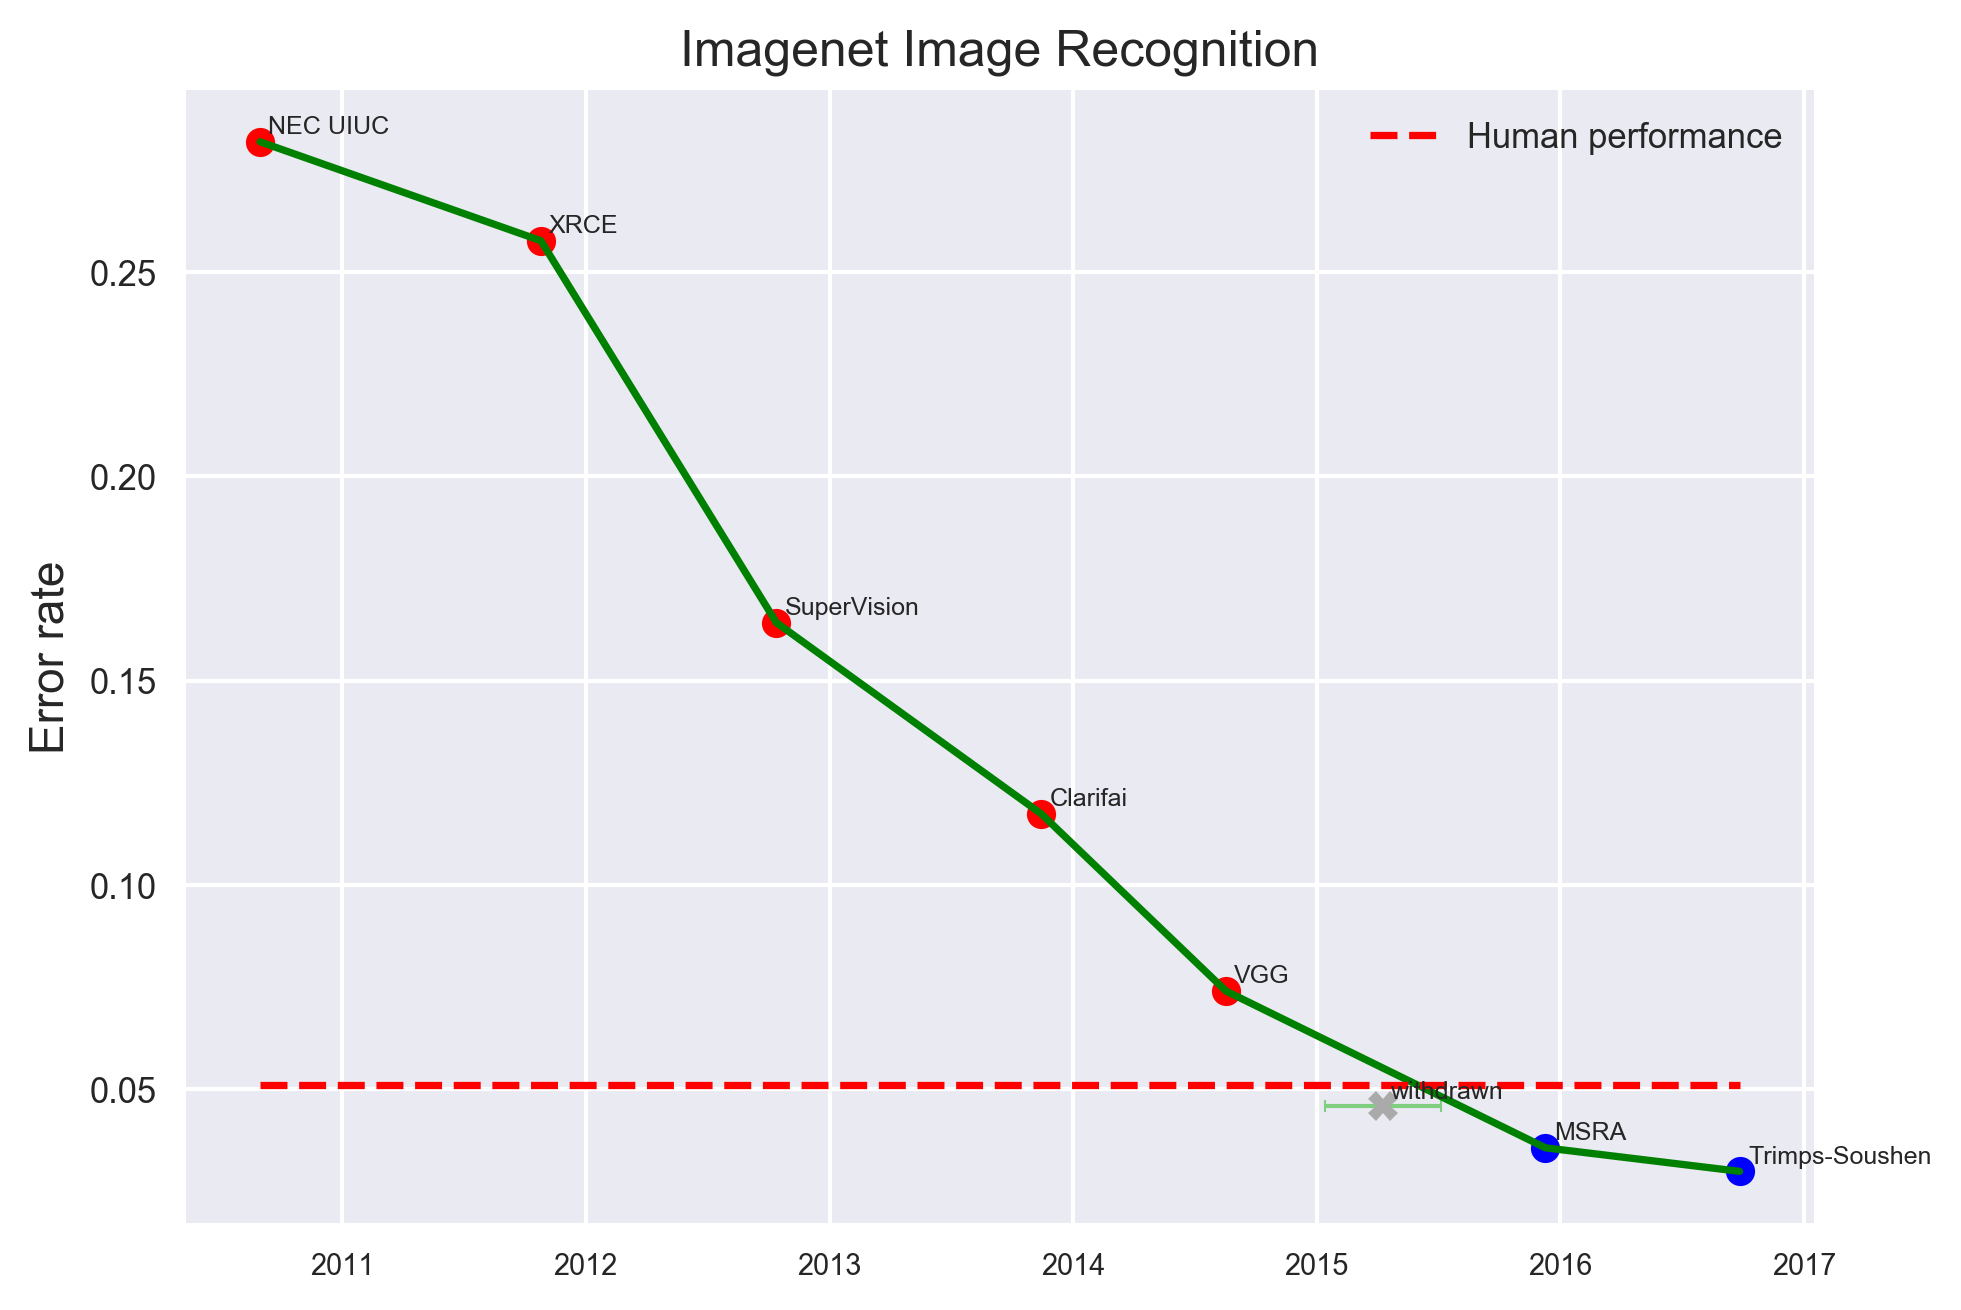

In [3]:
from data.vision import *
imagenet.graph()

<img src="images/vqa.jpg" style="width: 50%; height: 50%; float: right" float="right">

### Visual Question Answering


Comprehending an image involves more than recognising what objects or entities are within it, but recognising events, relationships, and context from the image. This problem requires both sophisticated image recognition, language, world-modelling, and "image comprehension". There are several datasets in use. The illustration is from VQA, which was generated by asking Amazon Mechanical Turk workers to propose questions about photos from Microsoft's COCO image collection.

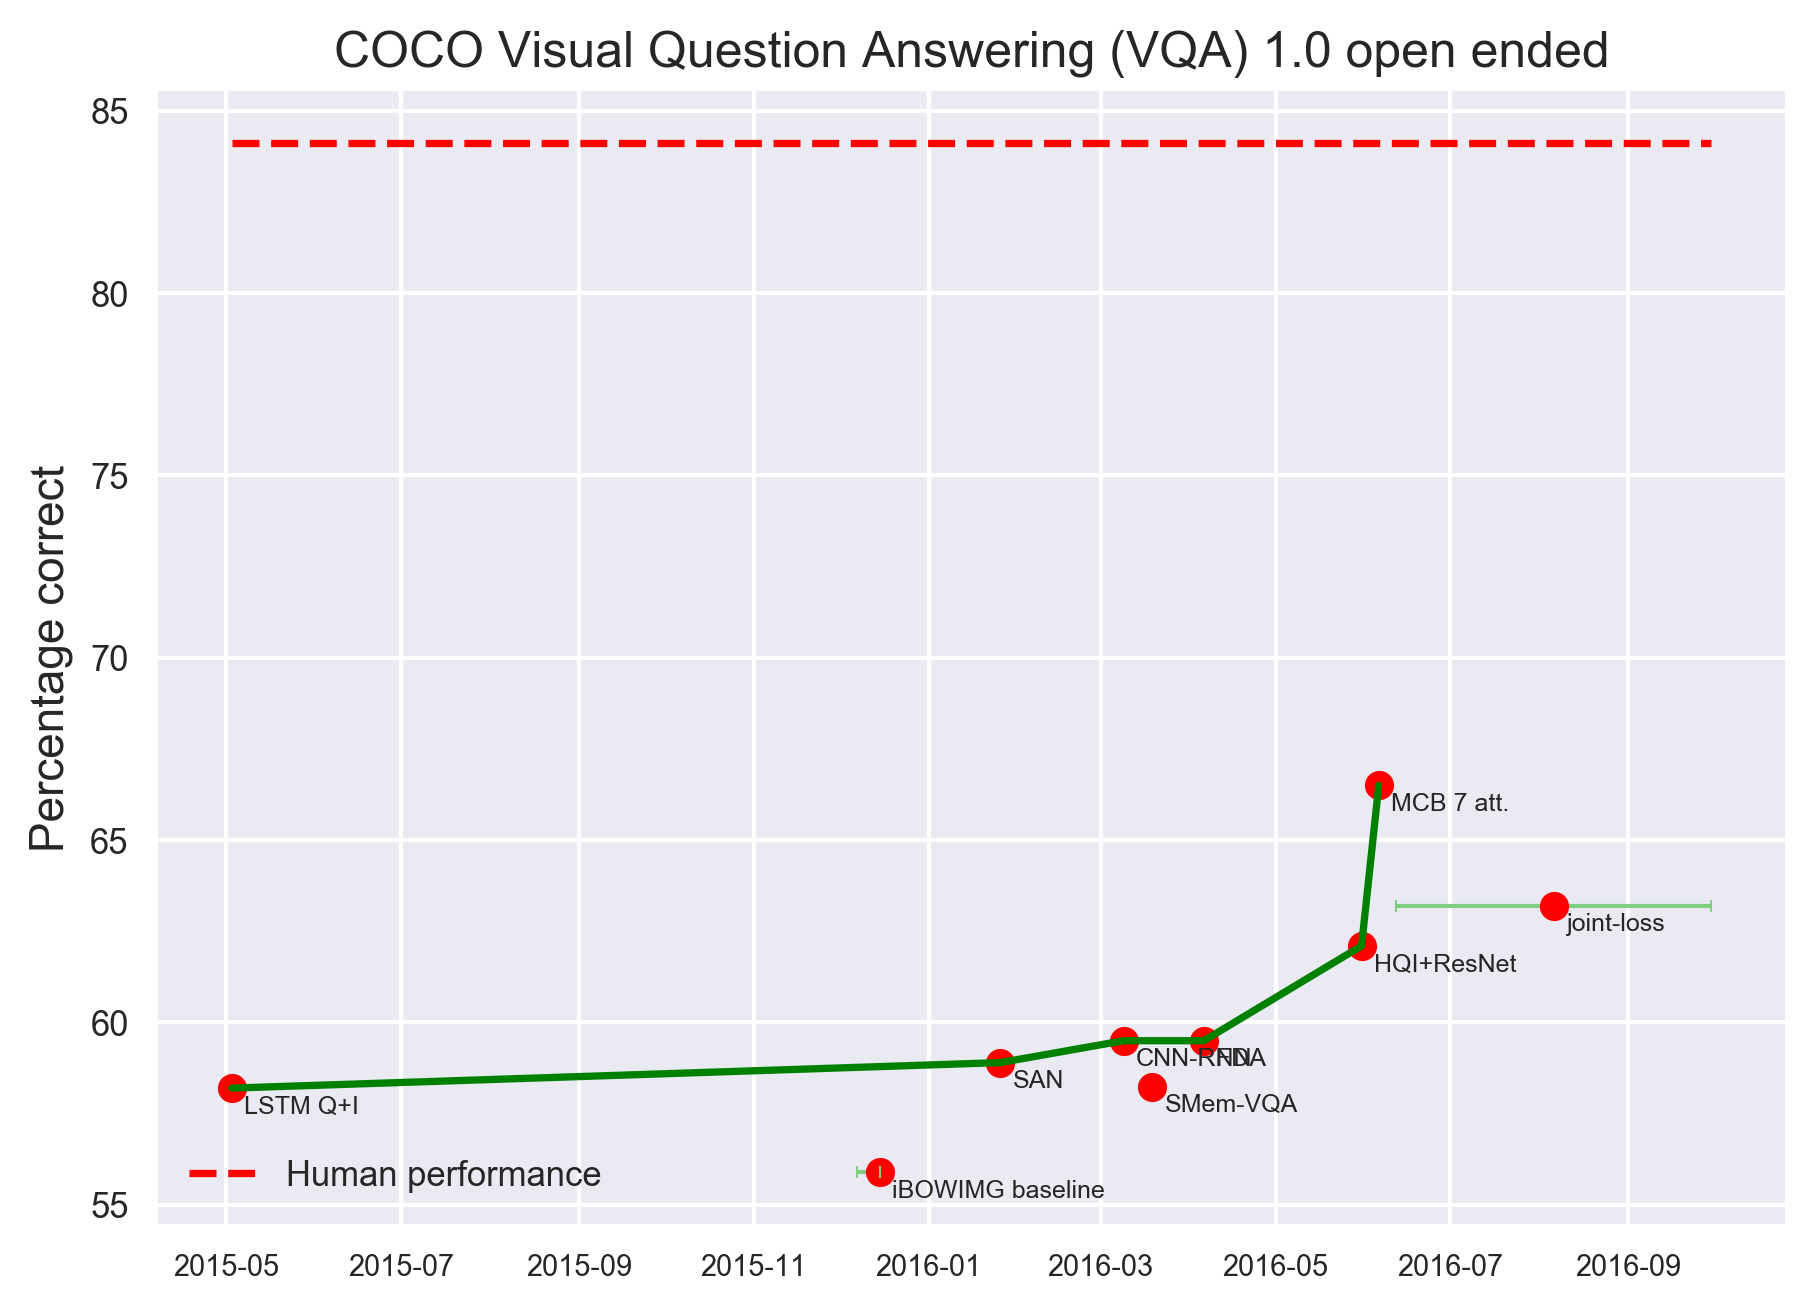

/home/pde/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


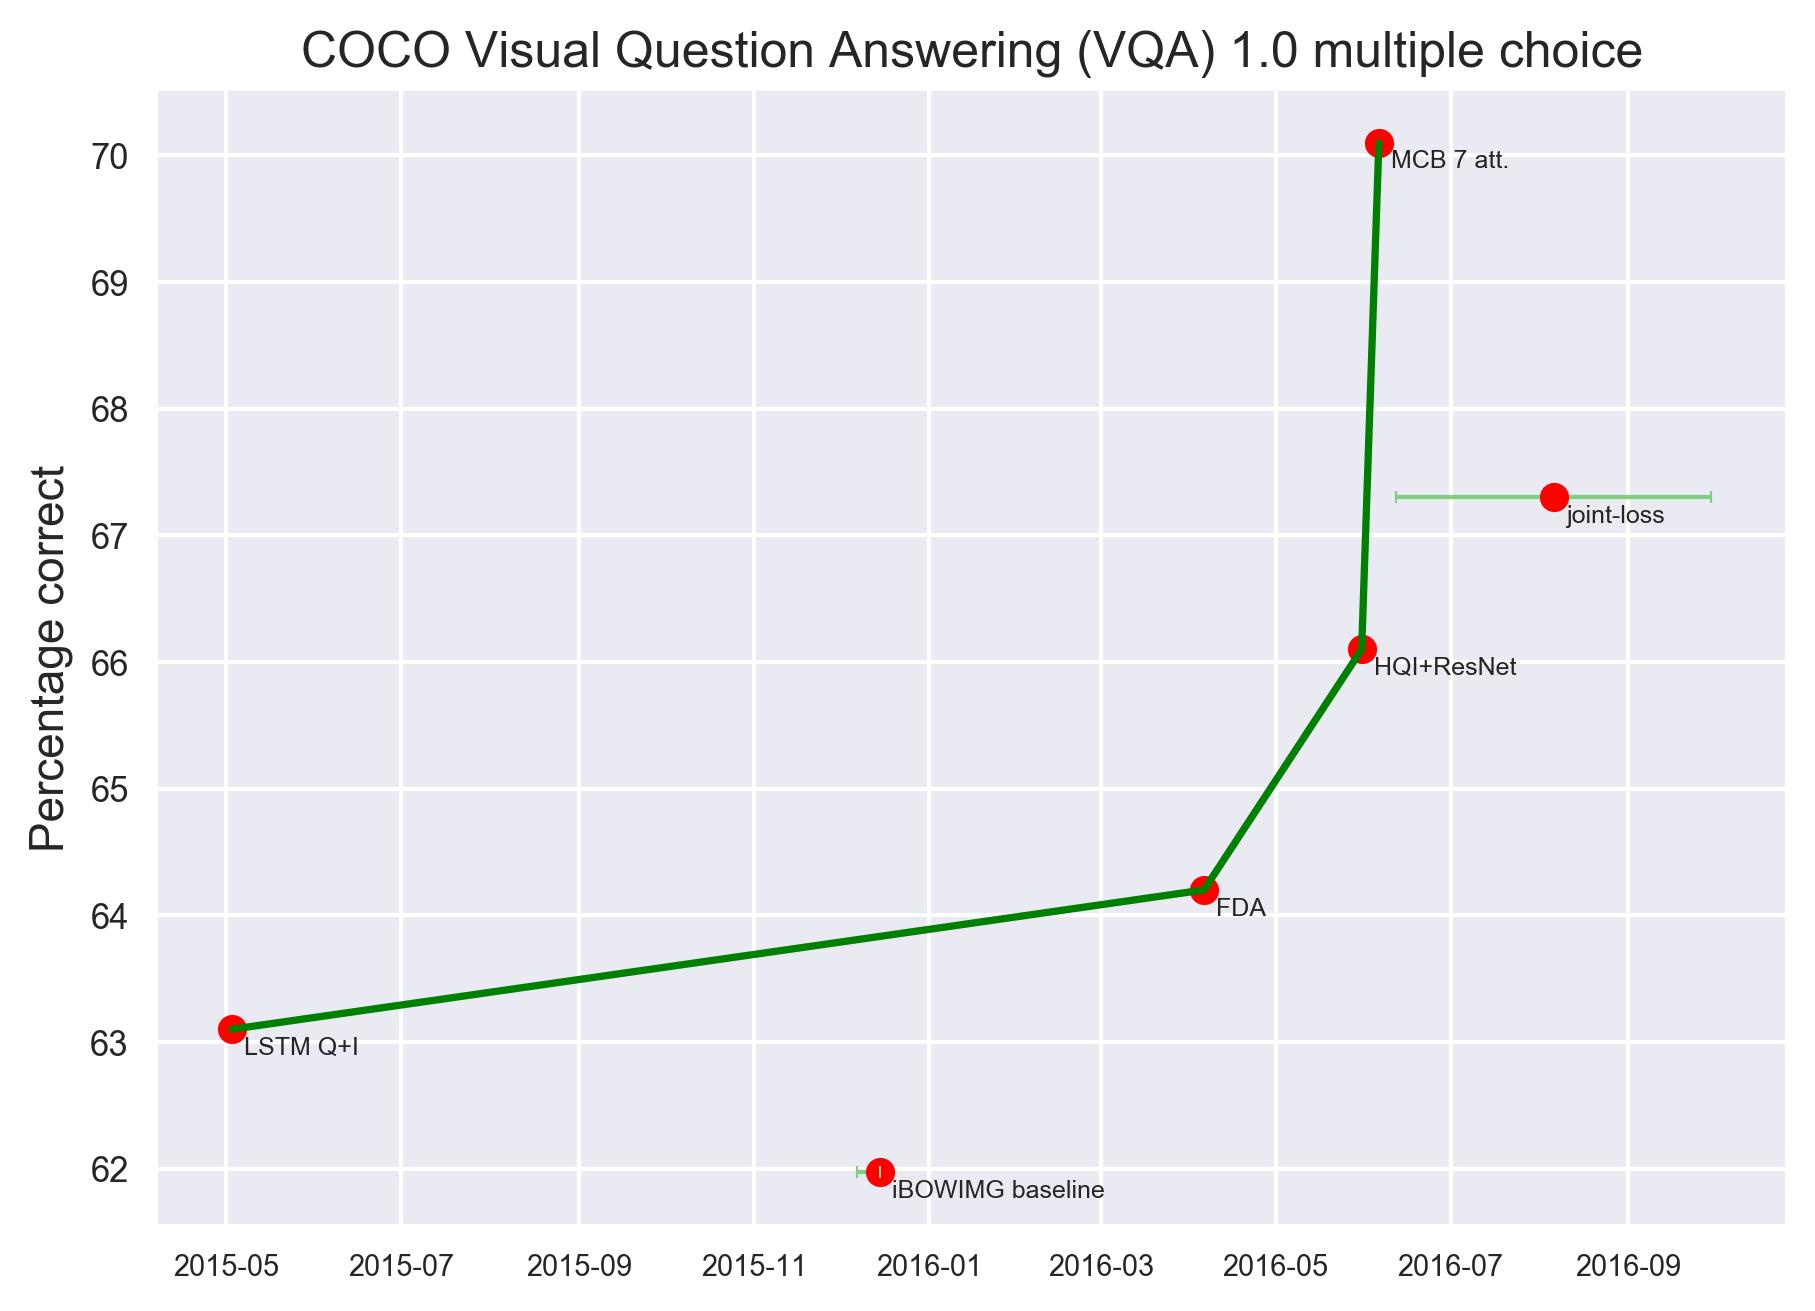

In [4]:

vqa_oe.graph()
vqa_mc.graph()

In [5]:
HTML(image_comprehension.tables())

Date,Algorithm,Result,Paper / Source
2015-05-03,LSTM Q+I,58.2,VQA: Visual Question Answering
2015-12-15,iBOWIMG baseline,55.89,Simple Baseline for Visual Question Answering
2016-01-26,SAN,58.9,Stacked Attention Networks for Image Question Answering
2016-03-09,CNN-RNN,59.5,Image Captioning and Visual Question Answering Based on Attributes and
2016-03-19,SMem-VQA,58.24,"Ask, Attend and Answer: Exploring Question-Guided Spatial Attention for"
2016-04-06,FDA,59.5,A Focused Dynamic Attention Model for Visual Question Answering
2016-05-31,HQI+ResNet,62.1,Hierarchical Co-Attention for Visual Question Answering
2016-06-06,MCB 7 att.,66.5,Multimodal Compact Bilinear Pooling for Visual Question Answering and( source code)
2016-08-06,joint-loss,63.2,Training Recurrent Answering Units with Joint Loss Minimization for VQA
Date,Algorithm,Result,Paper / Source


In [5]:
from data.vision import *
from data.awty import *

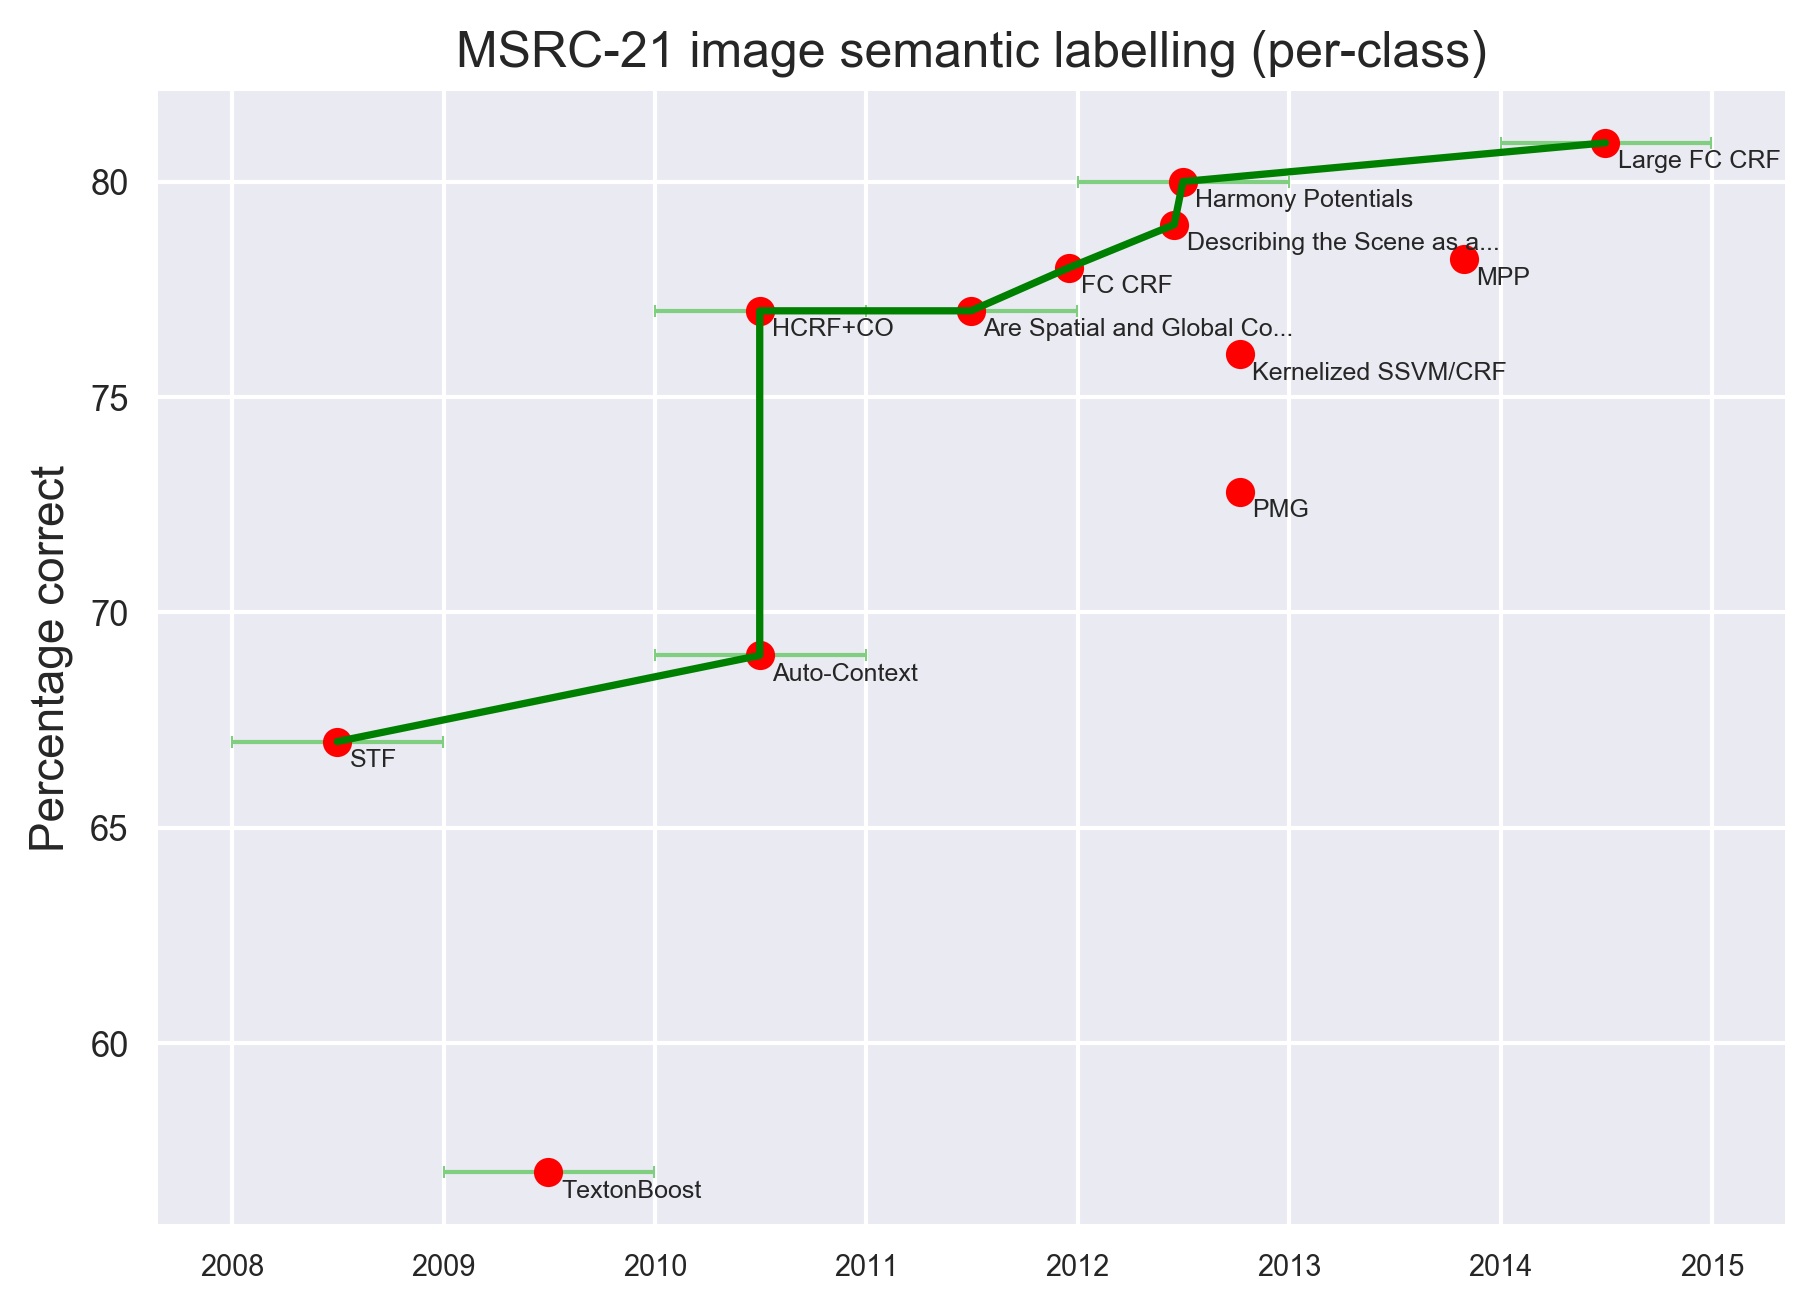

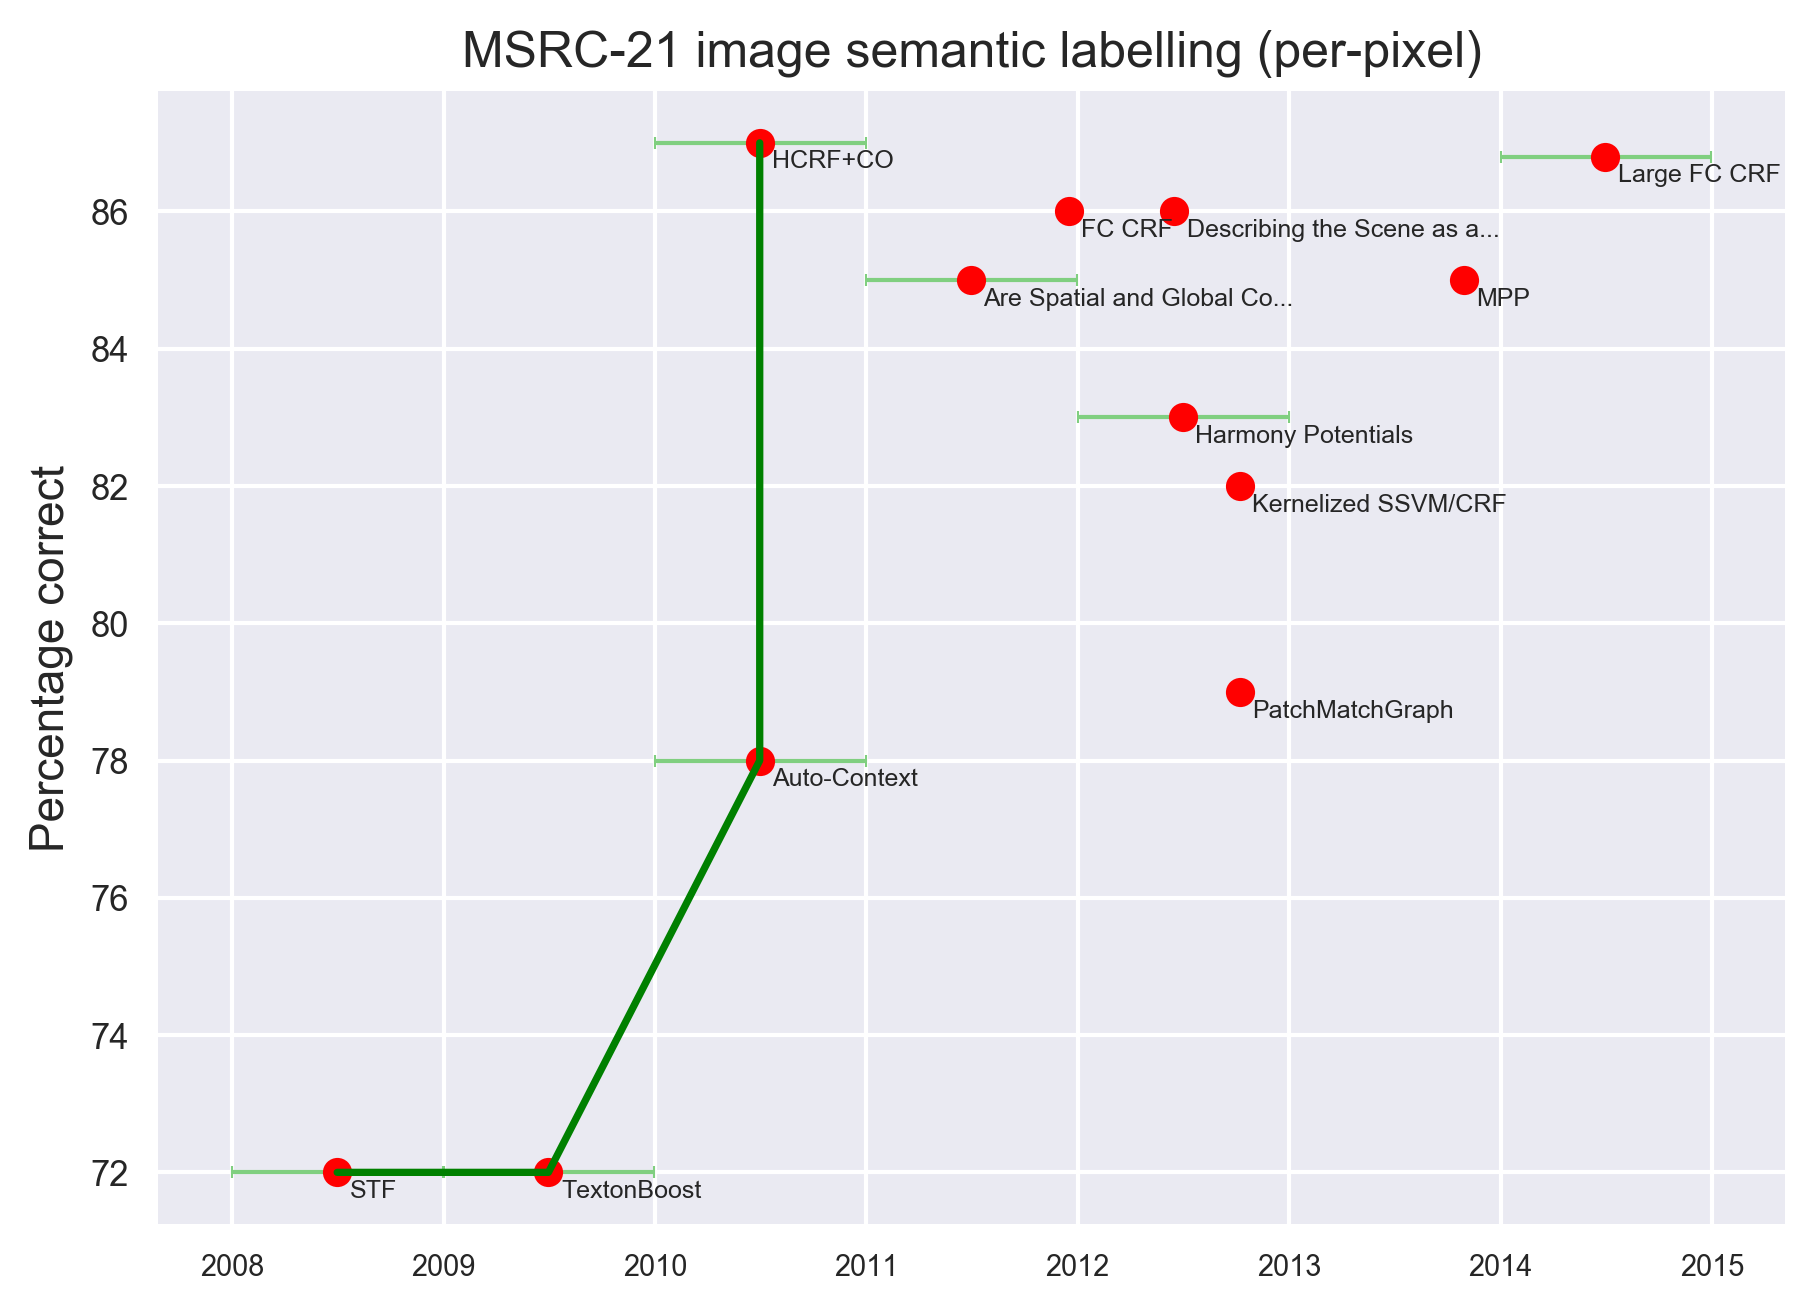

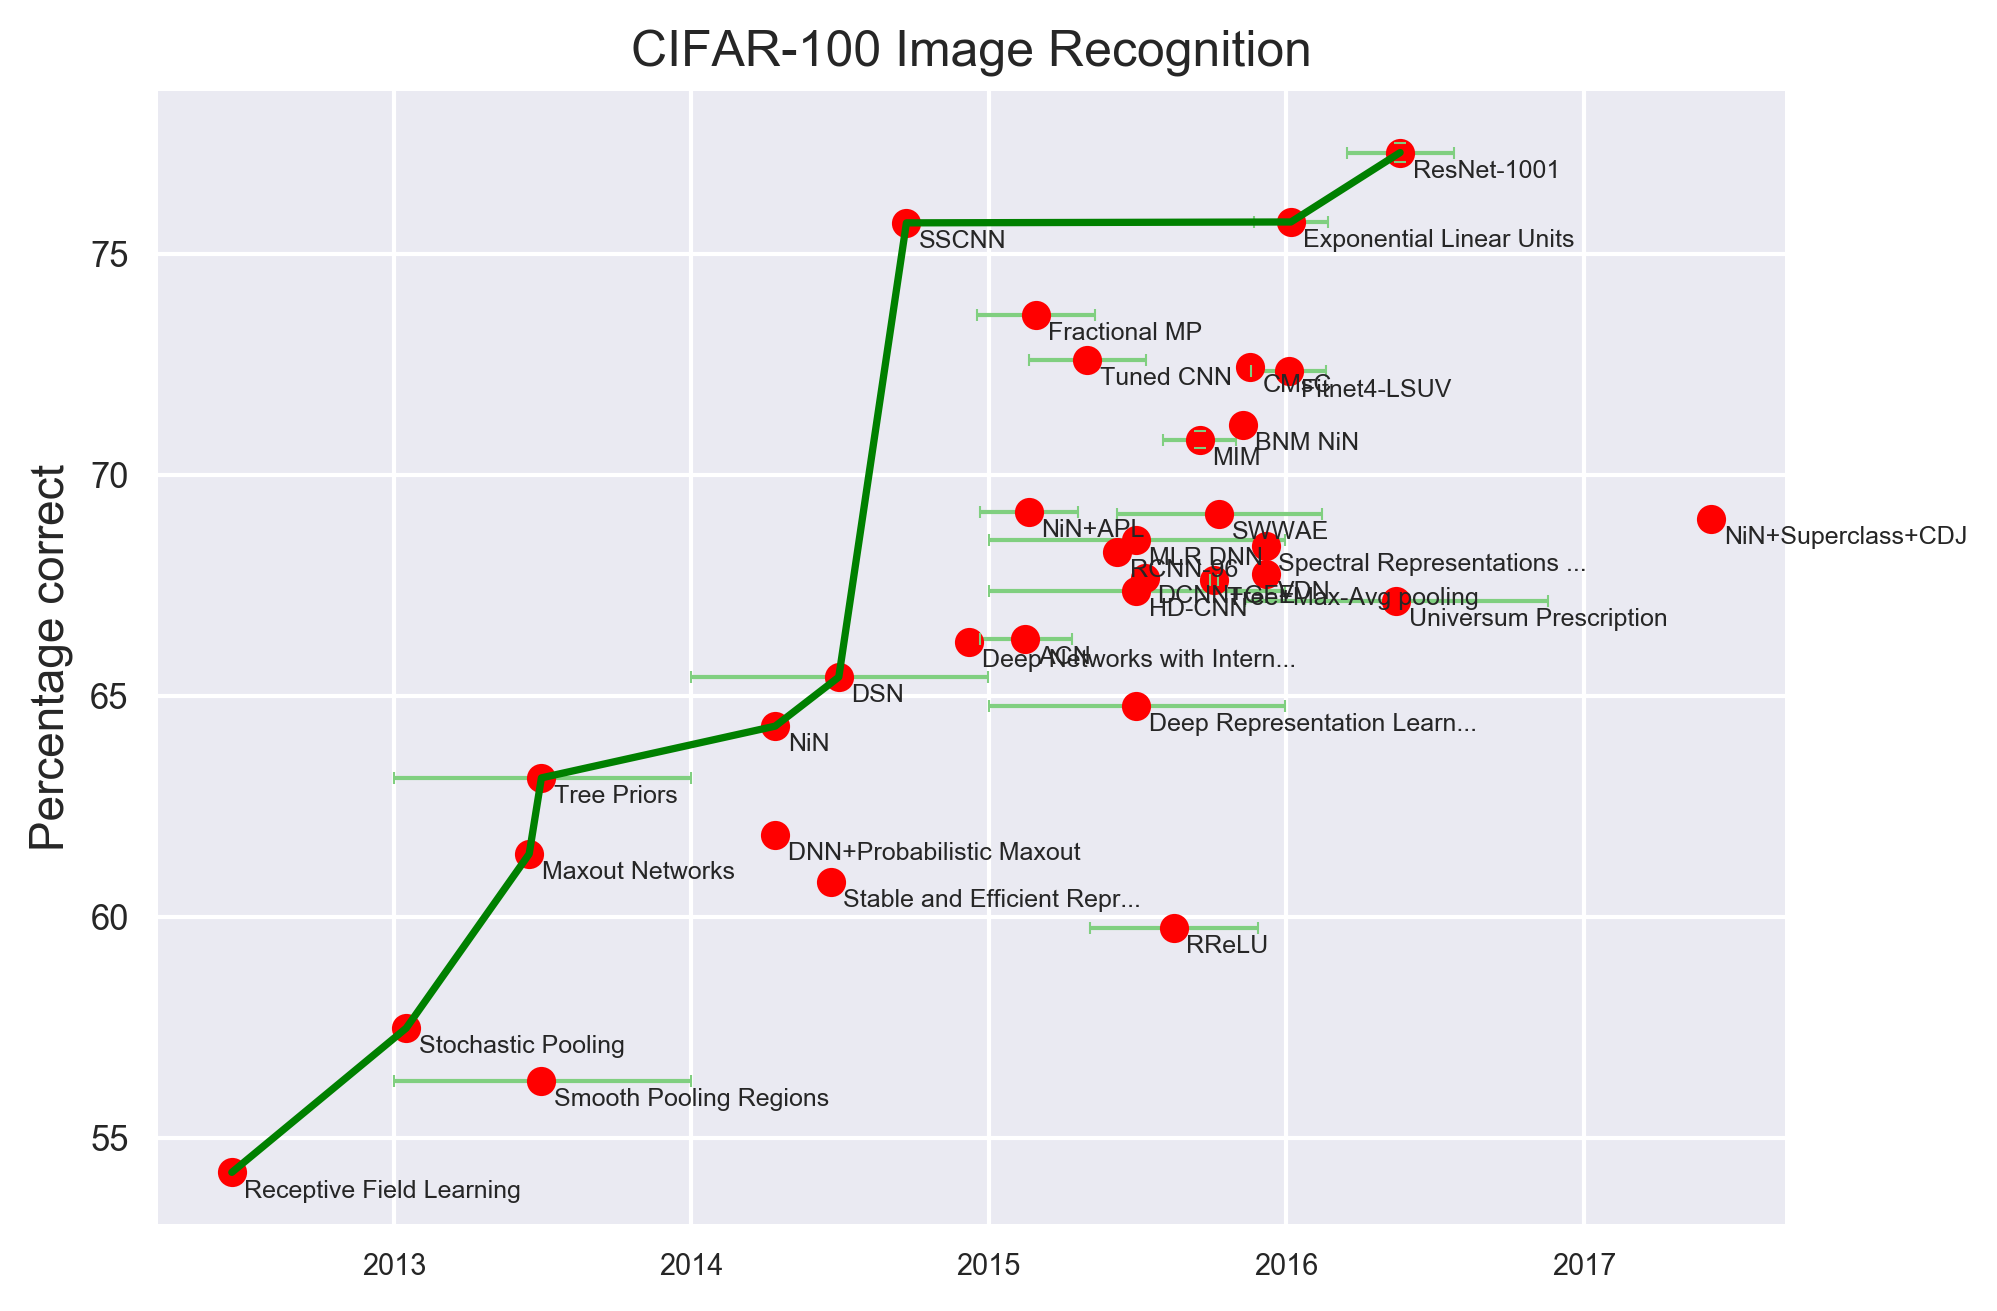

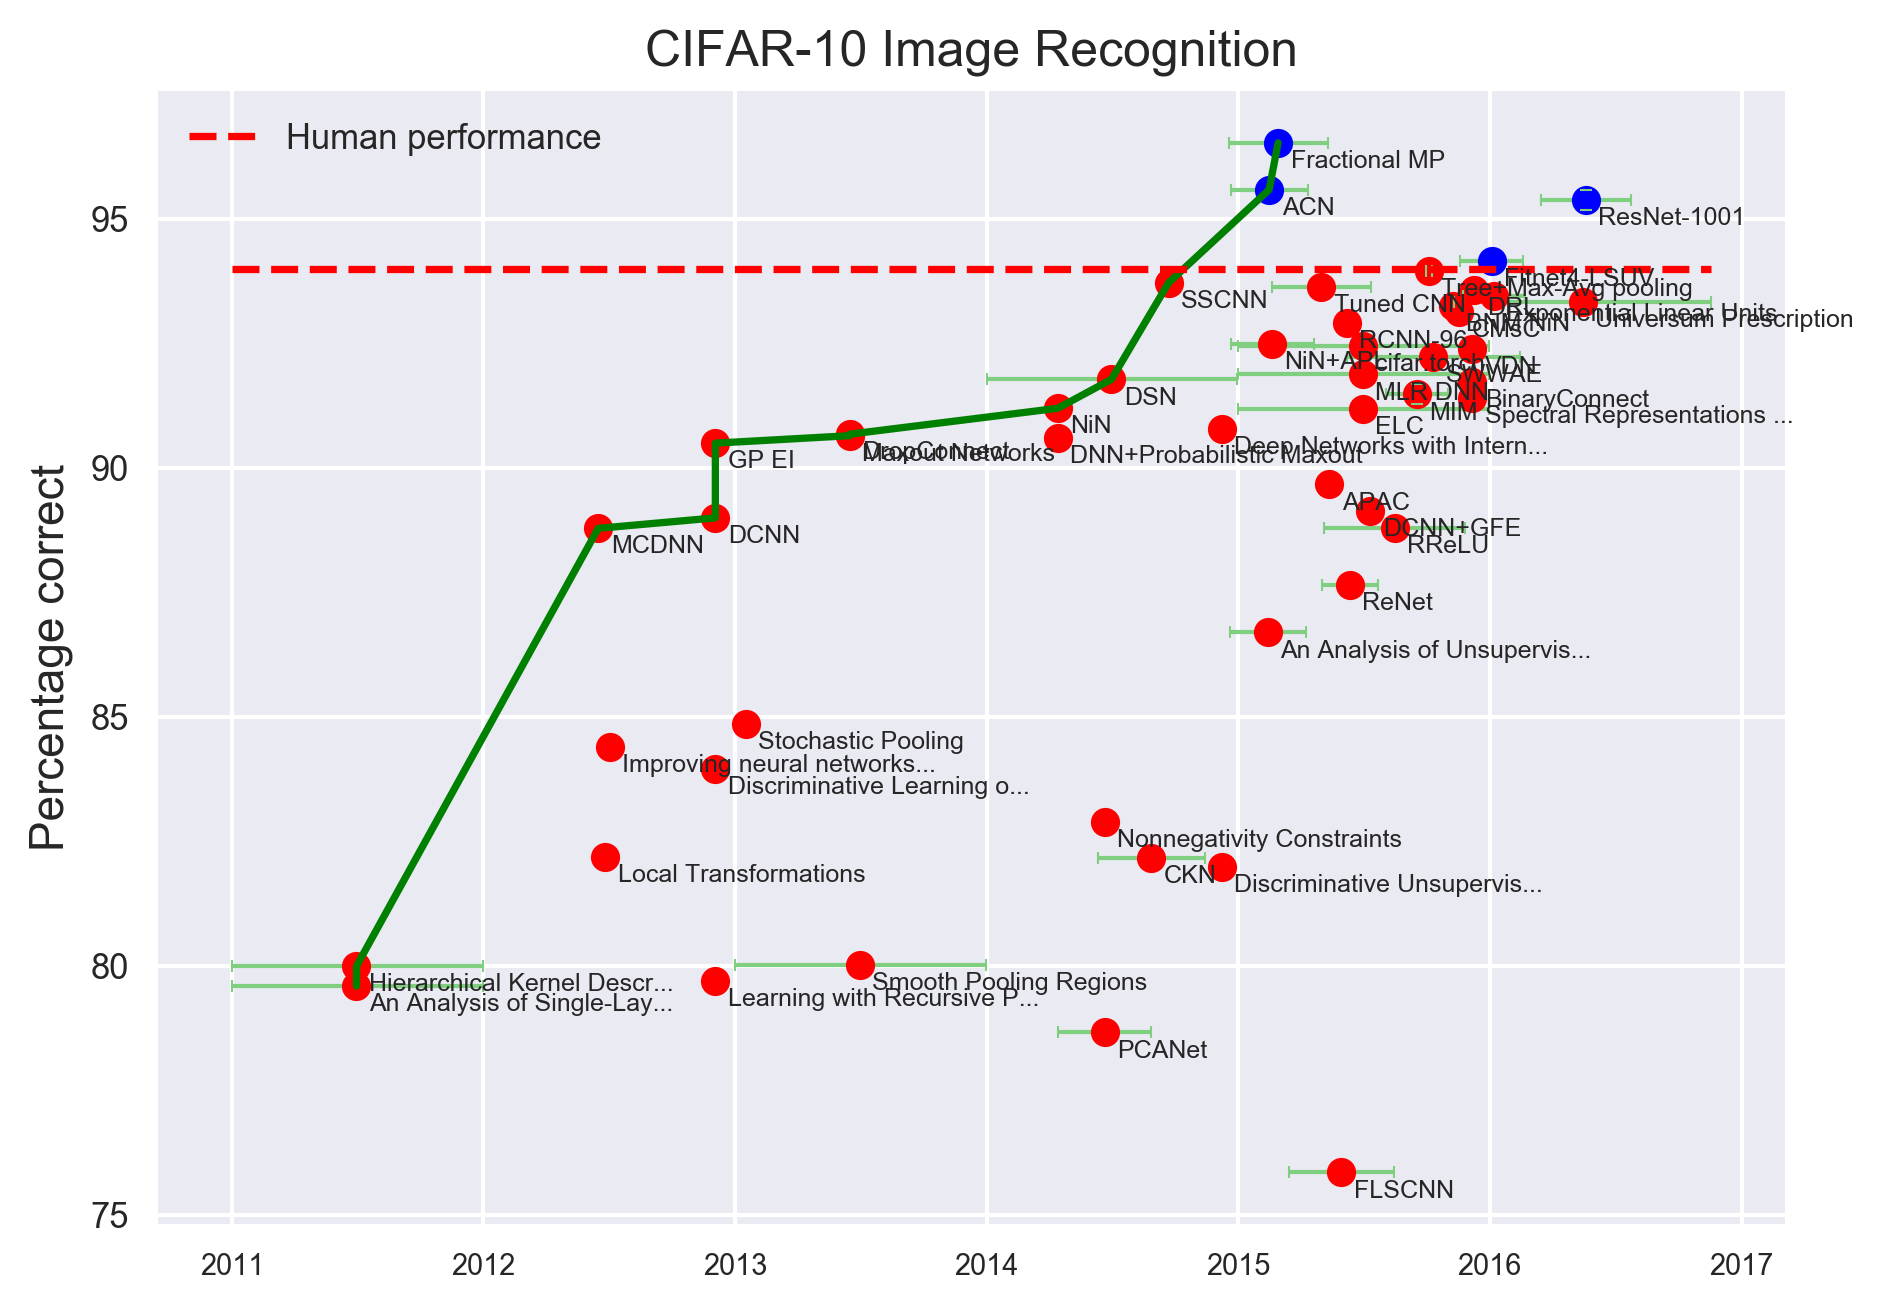

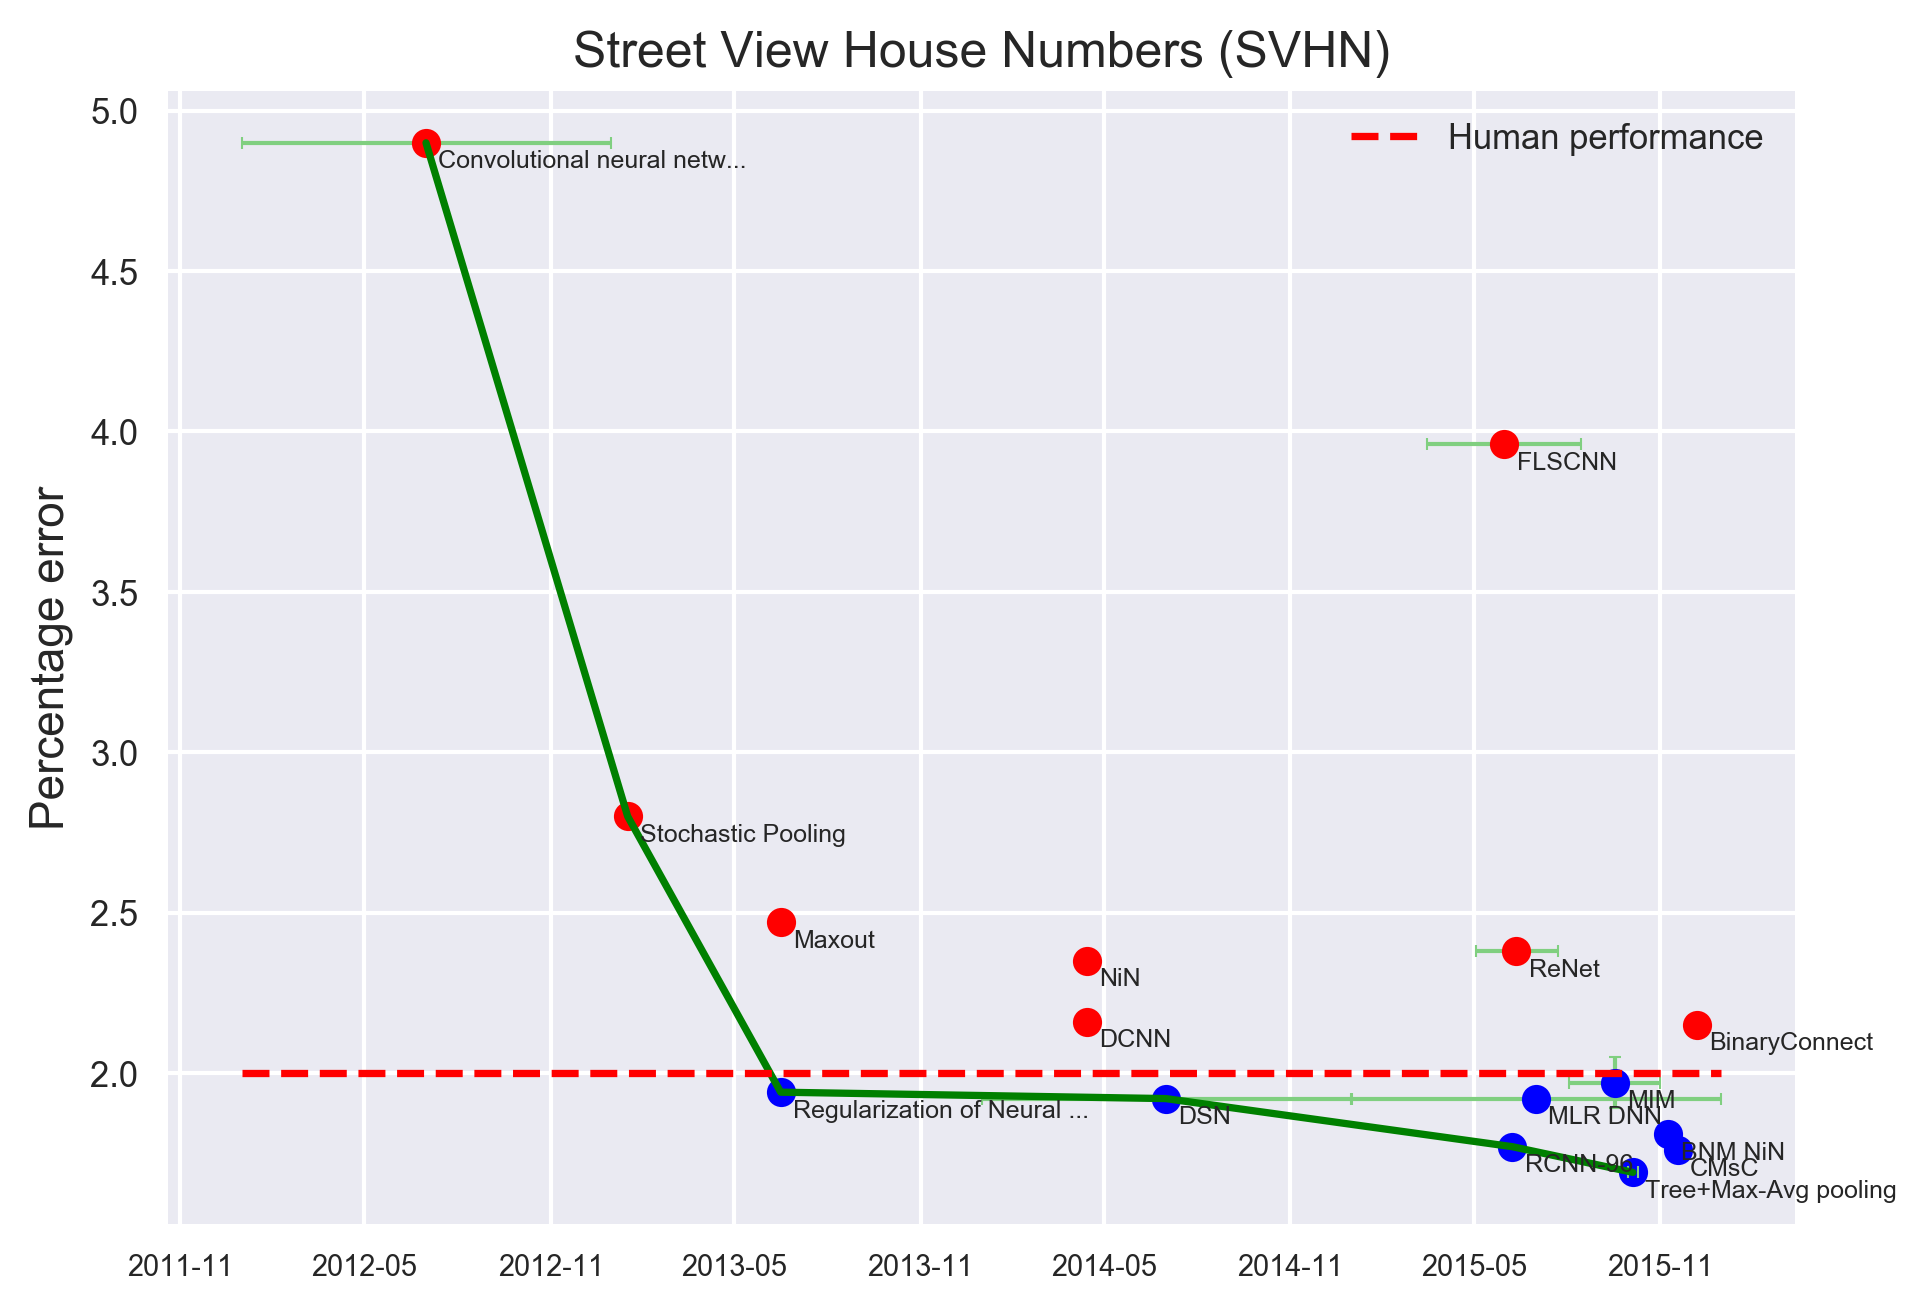

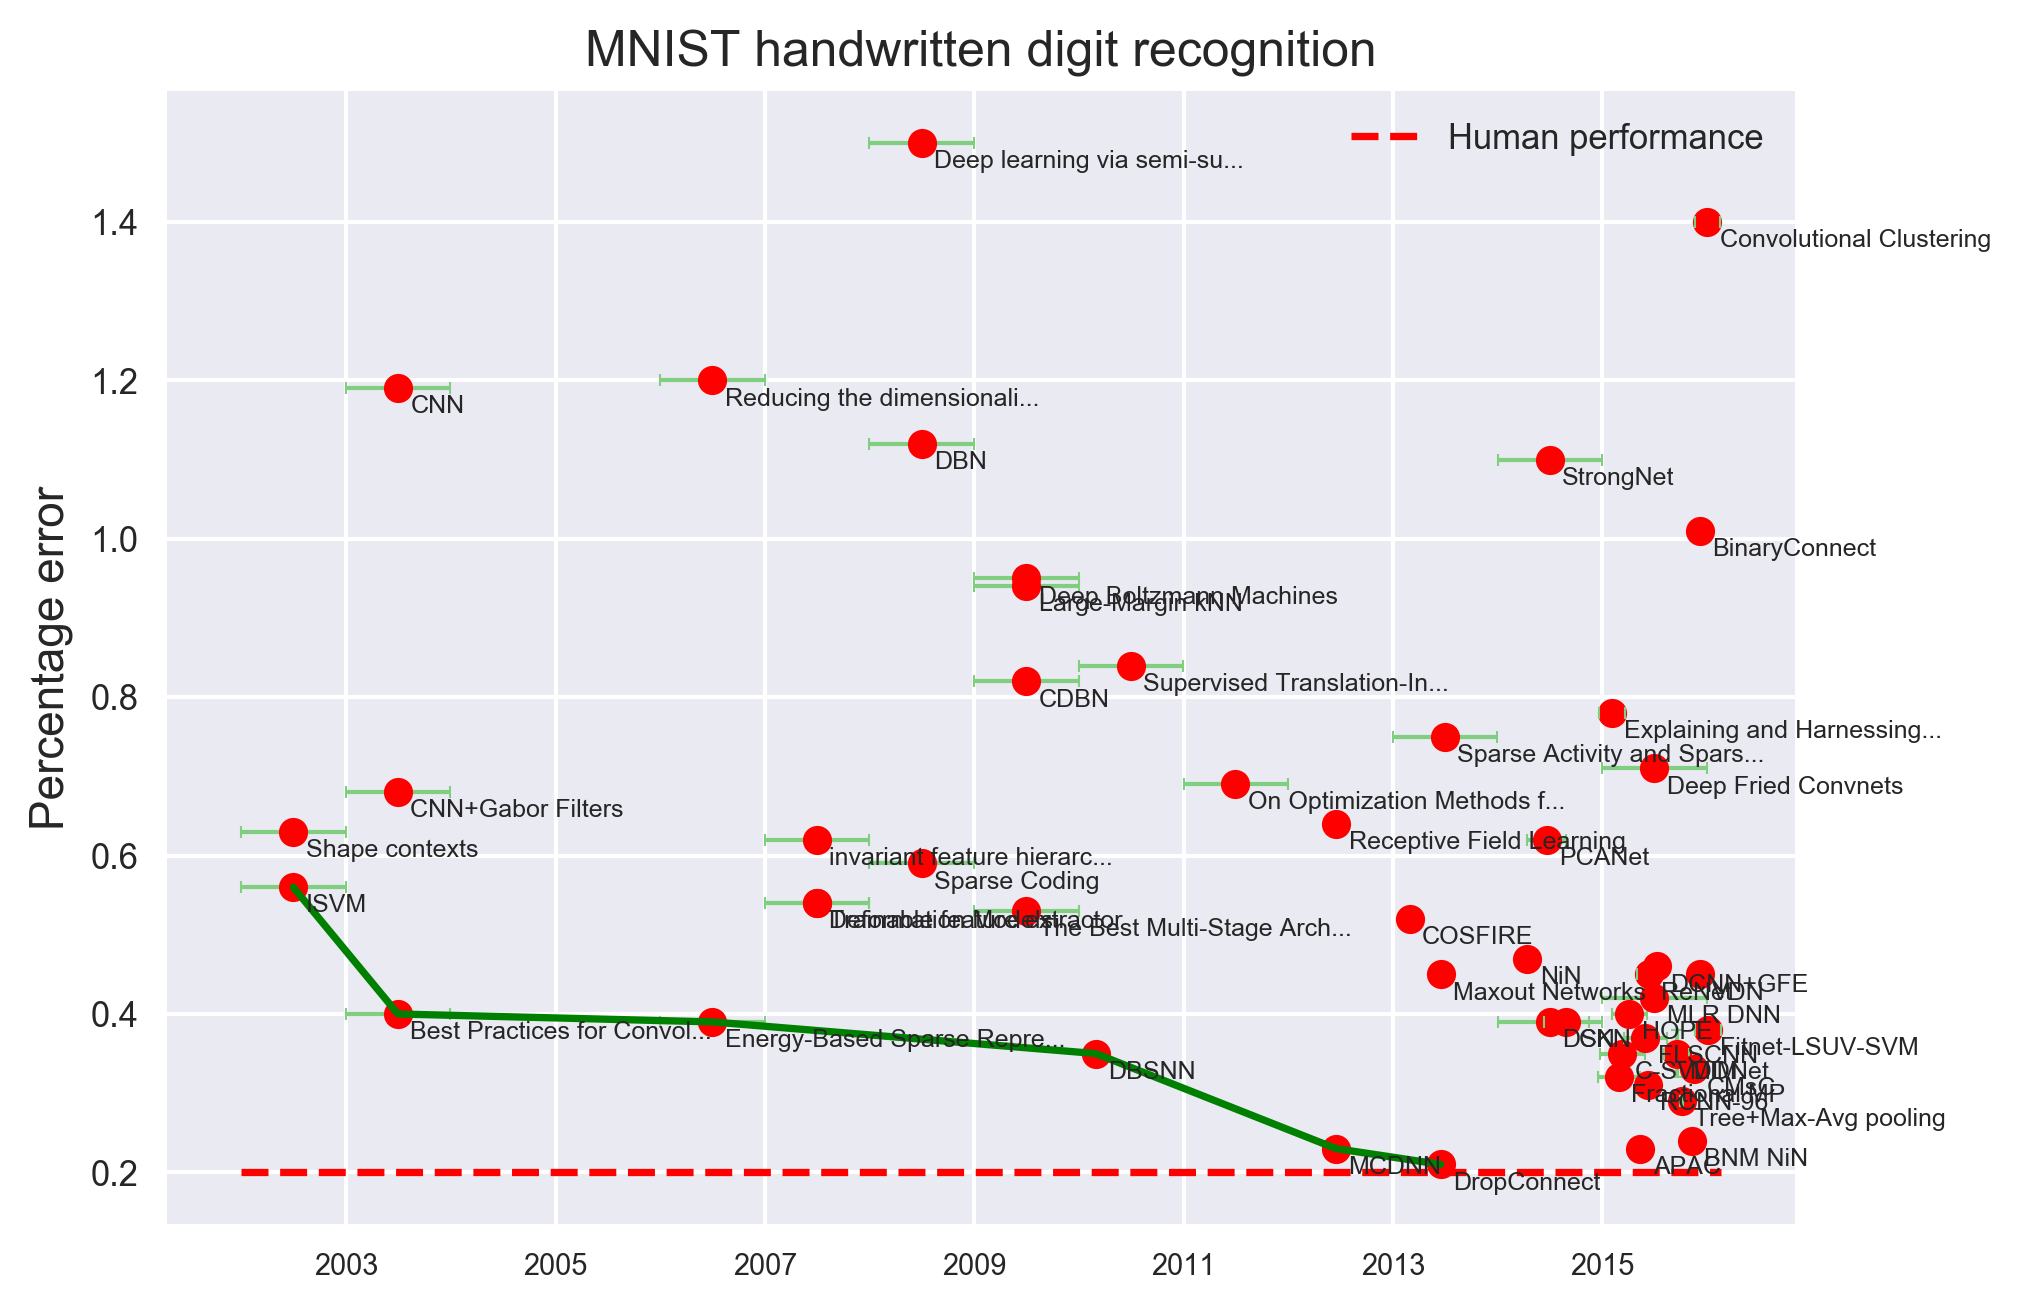

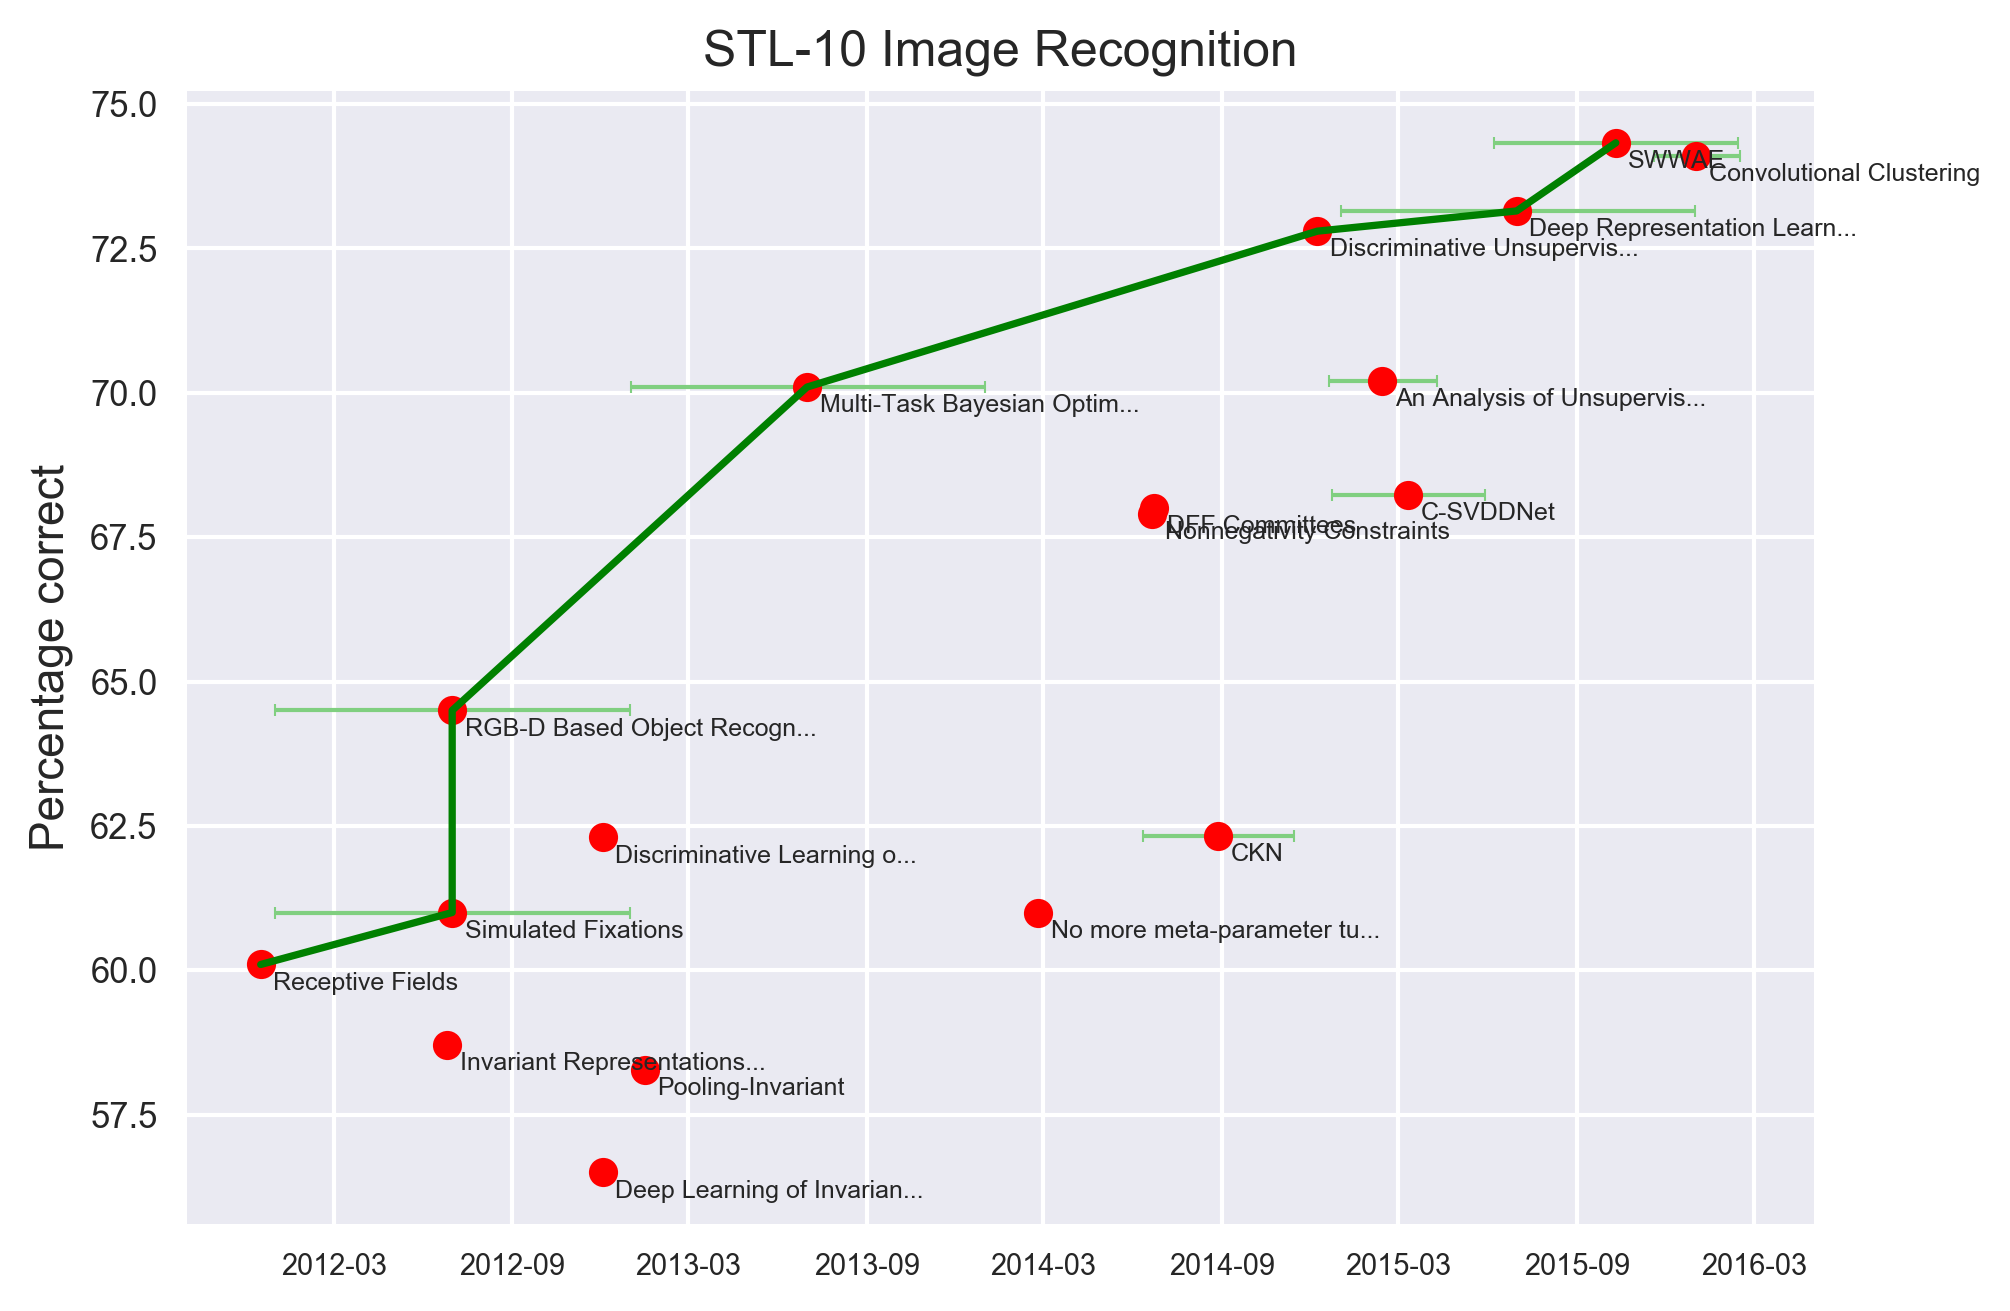

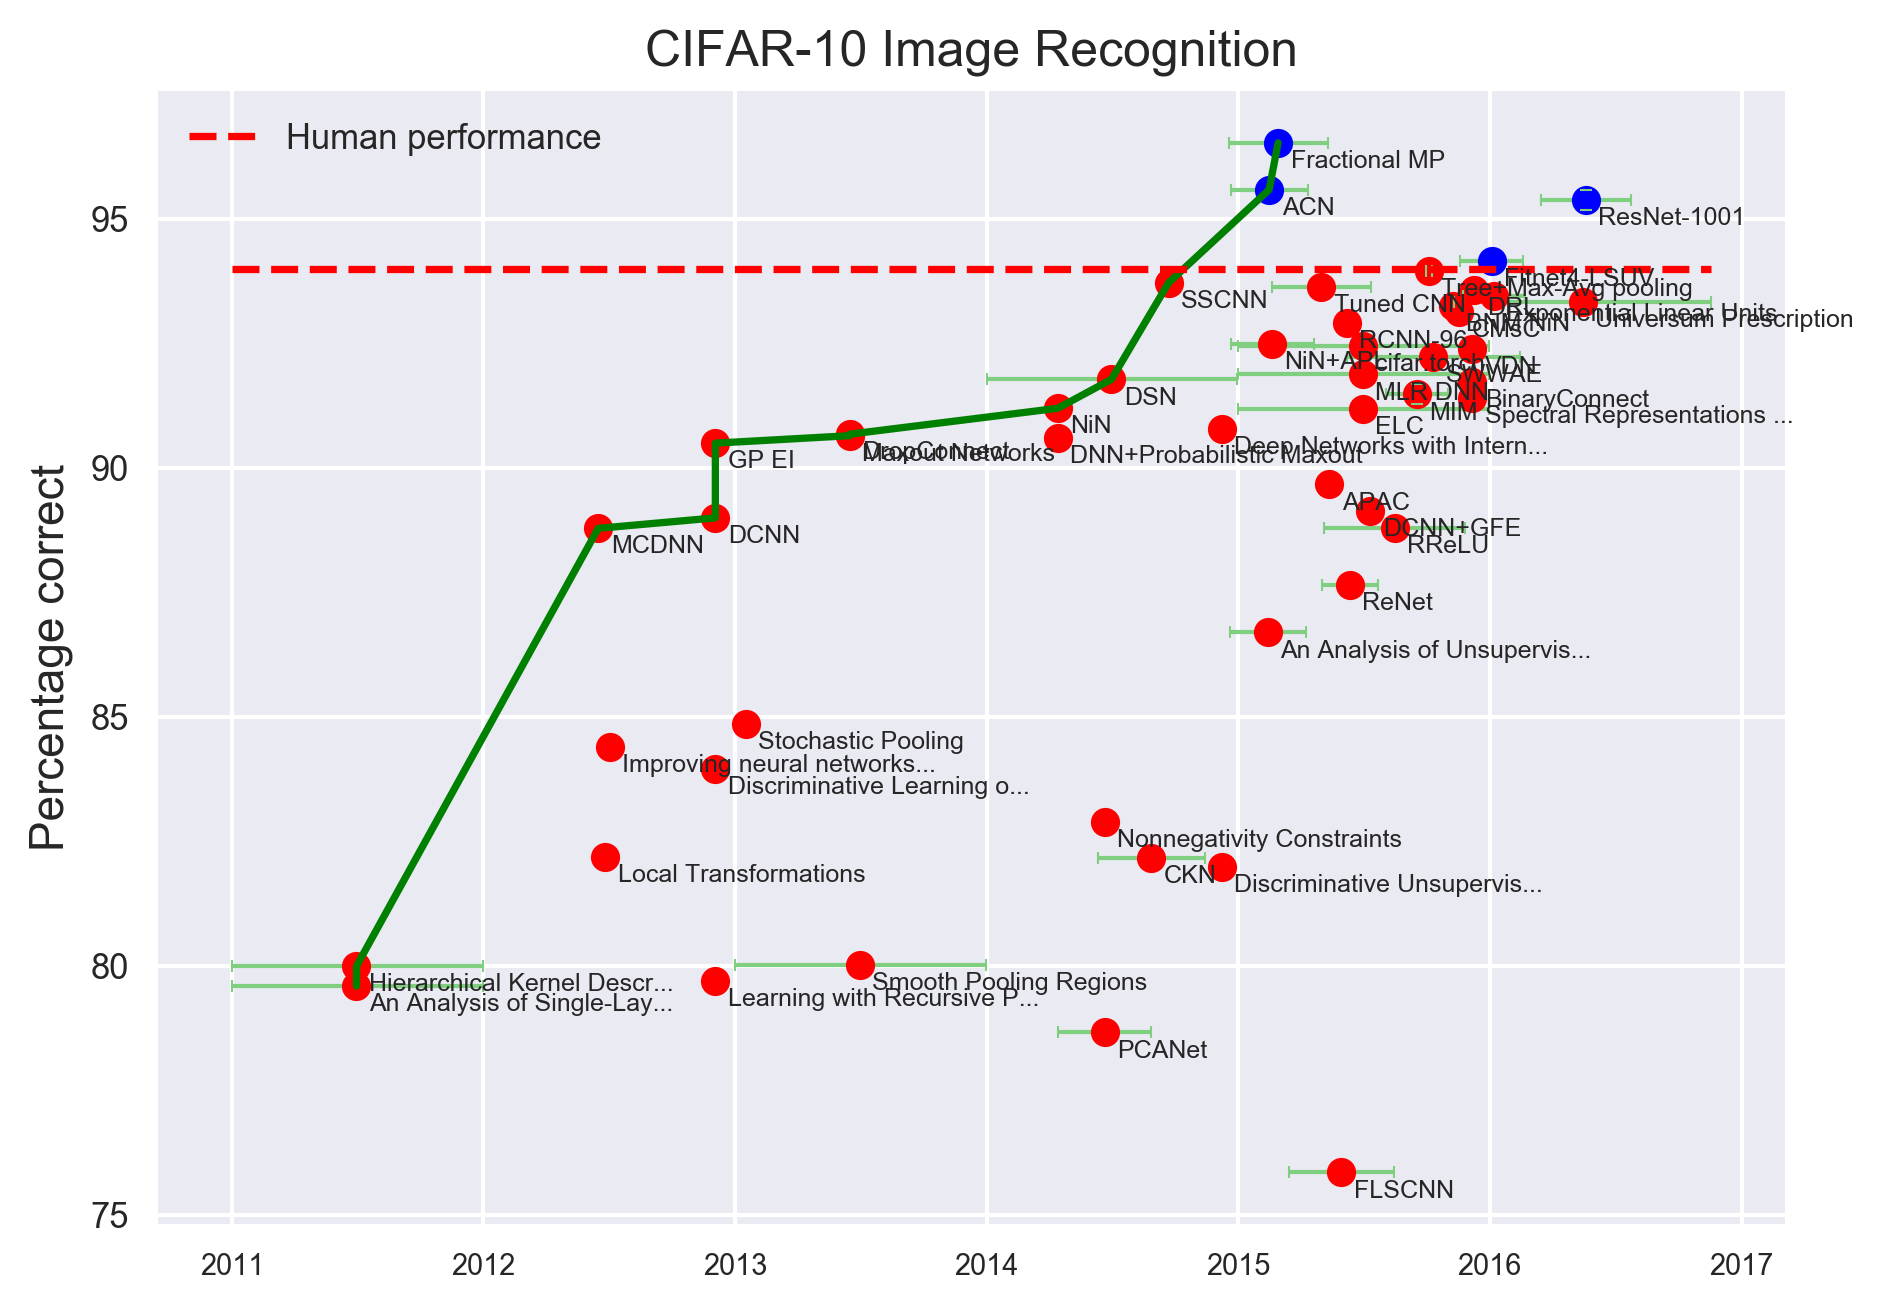

In [6]:
cifar100.measure(None, 100 - 22.71, "ResNet-1001", url="https://arxiv.org/pdf/1603.05027", uncertainty=0.22)
cifar10.measure(None, 100 - 4.62, "ResNet-1001", url="https://arxiv.org/pdf/1603.05027", uncertainty=0.20)
cifar100.measure(None, 69.0, "NiN+Superclass+CDJ", url="https://arxiv.org/abs/1706.02003")

for m in image_classification.metrics: 
    if m != imagenet: m.graph()
        
cifar10.graph()

AWTY, not yet imported:

```
Handling 'Pascal VOC 2011 comp3' detection_datasets_results.html#50617363616c20564f43203230313120636f6d7033
Skipping 40.6 mAP Fisher and VLAD with FLAIR CVPR 2014
Handling 'Leeds Sport Poses' pose_estimation_datasets_results.html#4c656564732053706f727420506f736573
69.2 %                  Strong Appearance and Expressive Spatial Models for Human Pose Estimation  ICCV 2013
64.3 %                                    Appearance sharing for collective human pose estimation  ACCV 2012
63.3 %                                                   Poselet conditioned pictorial structures  CVPR 2013
60.8 %                                Articulated pose estimation with flexible mixtures-of-parts  CVPR 2011
 55.6%           Pictorial structures revisited: People detection and articulated pose estimation  CVPR 2009
Handling 'Pascal VOC 2007 comp3' detection_datasets_results.html#50617363616c20564f43203230303720636f6d7033
Skipping 22.7 mAP Ensemble of Exemplar-SVMs for Object Detection and Beyond ICCV 2011
Skipping 27.4 mAP Measuring the objectness of image windows PAMI 2012
Skipping 28.7 mAP Automatic discovery of meaningful object parts with latent CRFs CVPR 2010
Skipping 29.0 mAP Object Detection with Discriminatively Trained Part Based Models PAMI 2010
Skipping 29.6 mAP Latent Hierarchical Structural Learning for Object Detection CVPR 2010
Skipping 32.4 mAP Deformable Part Models with Individual Part Scaling BMVC 2013
Skipping 34.3 mAP Histograms of Sparse Codes for Object Detection CVPR 2013
Skipping 34.3 mAP Boosted local structured HOG-LBP for object localization CVPR 2011
Skipping 34.7 mAP Discriminatively Trained And-Or Tree Models for Object Detection CVPR 2013
Skipping 34.7 mAP Incorporating Structural Alternatives and Sharing into Hierarchy for Multiclass Object Recognition and Detection CVPR 2013
Skipping 34.8 mAP Color Attributes for Object Detection CVPR 2012
Skipping 35.4 mAP Object Detection with Discriminatively Trained Part Based Models PAMI 2010
Skipping 36.0 mAP Machine Learning Methods for Visual Object Detection archives-ouvertes 2011
Skipping 38.7 mAP Detection Evolution with Multi-Order Contextual Co-occurrence CVPR 2013
Skipping 40.5 mAP Segmentation Driven Object Detection with Fisher Vectors ICCV 2013
Skipping 41.7 mAP Regionlets for Generic Object Detection ICCV 2013
Skipping 43.7 mAP Beyond Bounding-Boxes: Learning Object Shape by Model-Driven Grouping ECCV 2012
Handling 'Pascal VOC 2007 comp4' detection_datasets_results.html#50617363616c20564f43203230303720636f6d7034
Skipping 59.2 mAP Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition ECCV 2014
Skipping 58.5 mAP Rich feature hierarchies for accurate object detection and semantic segmentation CVPR 2014
Skipping 29.0 mAP Multi-Component Models for Object Detection ECCV 2012
Handling 'Pascal VOC 2010 comp3' detection_datasets_results.html#50617363616c20564f43203230313020636f6d7033
Skipping 24.98 mAP Learning Collections of Part Models for Object Recognition CVPR 2013
Skipping 29.4 mAP Discriminatively Trained And-Or Tree Models for Object Detection CVPR 2013
Skipping 33.4 mAP Object Detection with Discriminatively Trained Part Based Models PAMI 2010
Skipping 34.1 mAP Segmentation as selective search for object recognition ICCV 2011
Skipping 35.1 mAP Selective Search for Object Recognition IJCV 2013
Skipping 36.0 mAP Latent Hierarchical Structural Learning for Object  Detection CVPR 2010
Skipping 36.8 mAP Object Detection by Context and Boosted HOG-LBP ECCV 2010
Skipping 38.4 mAP Segmentation Driven Object Detection with Fisher Vectors ICCV 2013
Skipping 39.7 mAP Regionlets for Generic Object Detection ICCV 2013
Skipping 40.4 mAP Fisher and VLAD with FLAIR CVPR 2014
Handling 'Pascal VOC 2010 comp4' detection_datasets_results.html#50617363616c20564f43203230313020636f6d7034
Skipping 53.7 mAP Rich feature hierarchies for accurate object detection and semantic segmentation CVPR 2014
Skipping 40.4 mAP Bottom-up Segmentation for Top-down Detection CVPR 2013
Skipping 33.1 mAP Multi-Component Models for Object Detection ECCV 2012
```

In [16]:
from IPython.display import HTML
HTML(image_classification.tables())

Date,Algorithm,Result,Paper / Source
2010-08-31,NEC UIUC,0.28191,ImageNet Large Scale Visual Recognition Competition 2010 (ILSVRC2010)
2011-10-26,XRCE,0.2577,ImageNet Large Scale Visual Recognition Competition 2011 (ILSVRC2011)
2012-10-13,SuperVision,0.16422,ImageNet Large Scale Visual Recognition Competition 2012 (ILSVRC2012)
2013-11-14,Clarifai,0.11743,ImageNet Large Scale Visual Recognition Competition 2013 (ILSVRC2013)
2014-08-18,VGG,0.07405,ImageNet Large Scale Visual Recognition Competition 2014 (ILSVRC2014)
2015-04-10,withdrawn,0.0458,Deep Image: Scaling up Image Recognition
2015-12-10,MSRA,0.03567,ILSVRC2015 Results
2016-09-26,Trimps-Soushen,0.02991,ILSVRC2016
Date,Algorithm,Result,Paper / Source
2008-07-01,STF,67.0,Semantic Texton Forests for Image Categorization and Segmentation


# Game Playing

In principle, games are a sufficiently open-ended framework that all of intelligence could be captured within them. We can imagine a "ladder of games" which grow in sophistication and complexity, from simple strategy and arcade games to others which require very sophisticated language, world-modelling, vision and reasoning ability. At present, published reinforcement agents are climbing the first few rungs of this ladder.


## Abstract Strategy Games

As an easier case, abstract games like chess, go, checkers etc can be played with no knowldege of the human world or physics. Although this domain has largely been solved to super-human performance levels, there are a few ends that need to be tied up, especially in terms of having agents learn rules for arbitrary abstract games effectively given various plausible starting points (eg, textual descriptions of the rules or examples of correct play).

In [ ]:
from data.strategy_games import *
from IPython.display import HTML

table_html = computer_chess.table()
HTML(table_html)


## Real-time video games

Computer and video games are a very open-ended domain. It is possible that some existing or future games could be so elaborate that they are "AI complete". In the mean time, a lot of interesting progress is likely in exploring the "ladder of games" of increasing complexity on various fronts.

In [ ]:
from data.video_games import *
for m in simple_games.metrics: m.graph()

In [ ]:
from IPython.display import HTML

table_html = ""
for m in simple_games.metrics:
    html = m.table()
    if html is not None:
        HTML(table_html)
        table_html += html

HTML(table_html)


## Speech recognition


In [ ]:
"""
        http://melodi.ee.washington.edu/s3tp/

* * *
**_Word error rate on Switchboard (specify details): [Month, Year: Score [SWB]: Team].  Compiled by Jack Clark._**

A note about measurement: We're measuring Switchboard (SWB) and Call Home (CH) performance (mostly) from the Hub5'00 dataset, with main scores assesses in terms of word error rate on SWB. We also create 

Why do we care: Reflects the improvement of audio processing systems on speech over time.

"""
speech_recognition = Problem(name="Speech Recognition", attributes=["language", "agi"])
swb_hub_500 = speech_recognition.metric(name="Word error rate on Switchboard trained against the Hub5'00 dataset",
                                               scale=error_percent, target=5.9)
swb_hub_500.measure(date(2011,8,31), 16.1, "CD-DNN", "https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/CD-DNN-HMM-SWB-Interspeech2011-Pub.pdf")
swb_hub_500.measure(date(2012,4,27), 18.5, "DNN-HMM", "https://pdfs.semanticscholar.org/ce25/00257fda92338ec0a117bea1dbc0381d7c73.pdf?_ga=1.195375081.452266805.1483390947")

swb_hub_500.measure(date(2013,8,25), 12.9, "DNN MMI", "http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")
swb_hub_500.measure(date(2013,8,25), 12.6, "DNN sMBR", "http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")
swb_hub_500.measure(date(2013,8,25), 12.9, "DNN MPE", "http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")
swb_hub_500.measure(date(2013,8,25), 12.9, "DNN BMMI", "http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")

swb_hub_500.measure(date(2014,6,30), 16, "DNN", "https://arxiv.org/abs/1406.7806v1")

swb_hub_500.measure(date(2014,12,7), 20, "Deep Speech", "https://arxiv.org/abs/1412.5567")
swb_hub_500.measure(date(2014,12,7), 12.6, "Deep Speech + FSH", url="https://arxiv.org/abs/1412.5567") # TODO: why is this also included?

swb_hub_500.measure(date(2015,5,21), 8.0, "IBM 2015", "https://arxiv.org/abs/1505.05899") # TODO: (name check)
swb_hub_500.measure(date(2016,4,27), 6.9, "IBM 2016", "https://arxiv.org/abs/1604.08242v1") # TODO: (name check)

swb_hub_500.measure(date(2017,2,17), 6.9, "RNNLM", "https://arxiv.org/abs/1609.03528") # TODO: (name check)
swb_hub_500.measure(date(2017,2,17), 6.2, "Microsoft 2016", "https://arxiv.org/abs/1609.03528") # TODO: (name check)

swb_hub_500.measure(date(2016,10,17), 6.6, "CNN-LSTM", "https://arxiv.org/abs/1610.05256") # TODO: (name check)
swb_hub_500.measure(date(2016,10,17), 5.9, "CNN-LSTM","https://arxiv.org/abs/1610.05256") # TODO: (name check)

swb_hub_500.graph()

# Image Generation

In [ ]:

""" 
* * *
**_Generative models of CIFAR-10 Natural Images _****[Year: bits-per-subpixel, method]. Compiled by Durk Kingma.**

**Why we care:**
(1) The compression=prediction=understanding=intelligence view (see Hutter prize, etc.). (Note that perplexity, log-likelihood, and #bits are all equivalent measurements.)
(2) Learning a generative model is a prominent auxiliary task towards semi-supervised learning. Current SOTA semi-supervised classification results utilize generative models.
3) You're finding patterns in the data that let you compress it more efficiently. Ultimate pattern recognition benchmark because you're trying to find the patterns in all the data. 

"""

image_generation = Problem("Drawing pictures", ["vision", "agi"])
# note: this section is not on scene generation, but making the distinction seemed like a good idea.
scene_generation = Problem("Be able to generate complex scene e.g. a baboon receiving their degree at convocatoin.", ["vision", "world-modelling", "agi"])
scene_generation.add_subproblem(image_generation)

# NOTE: scale, and target need to be checked
image_generation_metric = image_generation.metric("Generative models of CIFAR-10 images", scale=bits_per_x, axis_label="Model entropy (bits per pixel)")

image_generation_metric.measure(date(2014,10,30), 4.48, "NICE", "https://arxiv.org/abs/1410.8516")
image_generation_metric.measure(date(2015,2,16), 4.13, "DRAW", "https://arxiv.org/abs/1502.04623")
image_generation_metric.measure(date(2016,5,27), 3.49, "Real NVP", "https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date(2016,6,15), 3.11, "VAE with IAF", "https://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow")
image_generation_metric.measure(date(2016,5,27), 3.0, "PixelRNN", "https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date(2016,11,4), 2.92, "PixelCNN++", "https://openreview.net/forum?id=BJrFC6ceg")

image_generation_metric.graph()

# Language Modelling and Comprehension

Text compression is one way to see how well machine learning systems are able to model human language. Shannon's [classic 1951 paper]() obtained an expiermental measure of human text compression performance at 0.6 - 1.3 bits per character: humans know, better than classic algorithms, what word is likely to come next in a piece of writing. More recent work ([Moradi 1998](https://pdfs.semanticscholar.org/48bc/ce35ceb72068723d5f360f388a073aadadca.pdf), Cover 1978) provides estimates that are text-relative and in the 1.3 bits per character (and for some texts, much higher) range.

In [ ]:
modelling_english = Problem("Accurate modelling of human language.", ["language", "agi"])
ptperplexity = modelling_english.metric(name="Penn Treebank (Perplexity when parsing English sentences)", scale=perplexity)
ptperplexity.measure(date(2016,9,26), 70.9, "Pointer Sentinel-LSTM", "https://arxiv.org/pdf/1609.07843v1.pdf")
ptperplexity.measure(date(2016,10,5), 73.4, "Variational LSTM", "https://arxiv.org/pdf/1512.05287v5.pdf")
ptperplexity.measure(date(2013,12,20), 107.5, "Deep RNN", "https://arxiv.org/abs/1312.6026")
ptperplexity.measure(date(2012,4,7), 78.8, "KN5+RNNME ensemble", "http://www.fit.vutbr.cz/~imikolov/rnnlm/google.pdf")
ptperplexity.measure(date(2012,4,7), 125.7, "KN5+cache baseline", "http://www.fit.vutbr.cz/~imikolov/rnnlm/google.pdf")

ptperplexity.measure(date(2012,7,27), 124.7, "RNNLM", "https://www.microsoft.com/en-us/research/wp-content/uploads/2012/07/rnn_ctxt_TR.sav_.pdf")
ptperplexity.measure(date(2012,7,27), 74.1, "RNN-LDA+all", "https://www.microsoft.com/en-us/research/wp-content/uploads/2012/07/rnn_ctxt_TR.sav_.pdf")
ptperplexity.measure(date(2012,7,27), 113.7, "RNN-LDA LM", "https://www.microsoft.com/en-us/research/wp-content/uploads/2012/07/rnn_ctxt_TR.sav_.pdf")
ptperplexity.measure(date(2012,7,27), 92.0, "RNN-LDA LM+KN5+cache", "https://www.microsoft.com/en-us/research/wp-content/uploads/2012/07/rnn_ctxt_TR.sav_.pdf")
ptperplexity.measure(date(2012,7,27), 80.1, "RNN-LDA ensemble", "https://www.microsoft.com/en-us/research/wp-content/uploads/2012/07/rnn_ctxt_TR.sav_.pdf")
ptperplexity.measure(None, 68.7, "RNN Dropout Regularization", "https://arxiv.org/abs/1409.2329v1")
ptperplexity.measure(None, 68.5, "RHN", "https://arxiv.org/pdf/1607.03474v3")
ptperplexity.measure(None, 66, "RHN+WT", "https://arxiv.org/pdf/1607.03474v3")
ptperplexity.measure(None, 71.3, "Variational RHN", "https://arxiv.org/abs/1607.03474")



ptperplexity.graph()


In [ ]:
hp_compression = modelling_english.metric(name="Hutter Prize (bits per character to encode English text)", scale=bits_per_x, target=1.3)
hp_compression.measure(date(2016,10,31), 1.313, "Surprisal-Driven Zoneout",
                   "https://pdfs.semanticscholar.org/e9bc/83f9ff502bec9cffb750468f76fdfcf5dd05.pdf")
hp_compression.measure(date(2016,10,19), 1.37, "Surprisal-Driven Feedback RNN",
                   "https://arxiv.org/pdf/1608.06027.pdf")
hp_compression.measure(date(2016,9,27), 1.39, "Hypernetworks", "https://arxiv.org/abs/1609.09106")
hp_compression.measure(date(2016,9,6), 1.32, " Hierarchical Multiscale RNN", "https://arxiv.org/abs/1609.01704")
hp_compression.measure(date(2016,7,12), 1.32, "Recurrent Highway Networks", "https://arxiv.org/abs/1607.03474")
hp_compression.measure(date(2015,7,6), 1.47, "Grid LSTM", "https://arxiv.org/abs/1507.01526")
hp_compression.measure(date(2015,2,15), 1.58, "Gated Feedback RNN", "https://arxiv.org/abs/1502.02367")
# we need to match/double check the release date of the specific version of cmix that got this performance?
# hp_compression.measure(date(2014,4,13), 1.245, "cmix", "http://www.byronknoll.com/cmix.html")
hp_compression.measure(date(2013,8,4), 1.67, "RNN, LSTM", "https://arxiv.org/abs/1308.0850")
hp_compression.measure(date(2011,6,28), 1.60, "RNN", "http://www.cs.utoronto.ca/~ilya/pubs/2011/LANG-RNN.pdf")
hp_compression.graph()

LAMBADA is a challenging language modelling dataset in which the model has to predict a next word in a discourse, when that exact word has not occurred in the test. For instance, given a context like this:

> He shook his head, took a step back and held his hands up as he tried to smile without losing a cigarette. “Yes you can,” Julia said in a reassuring voice. “I’ve already focused on my friend. You just have to click the shutter, on top, here.”

And a target sentence: 

> He nodded sheepishly, through his cigarette away and took the \_\_\_\_\_\_\_\_\_.

The task is to guess the target word "**camera**".


In [ ]:
lambada = modelling_english.metric("LAMBADA prediction of words in discourse", url="https://arxiv.org/abs/1606.06031",
                                   scale=correct_percent, target=86, target_source="https://arxiv.org/abs/1610.08431v3")
lambada.measure(None, 21.7, "Stanford Reader", url="https://arxiv.org/abs/1610.08431v3", algorithm_src_url="https://arxiv.org/abs/1606.02858")
lambada.measure(None, 32.1, "Modified Stanford", url="https://arxiv.org/abs/1610.08431v3", algorithm_src_url="https://arxiv.org/abs/1606.02858")
lambada.measure(None, 49.0, "GA + feat.", url="https://arxiv.org/abs/1610.08431v3", algorithm_src_url="https://arxiv.org/abs/1606.01549v2")
lambada.measure(None, 44.5, "AS + feat.", url="https://arxiv.org/abs/1610.08431v3", algorithm_src_url="https://arxiv.org/abs/1603.01547")
lambada.measure(None, 51.6, "MAGE (48)", url="https://arxiv.org/abs/1703.02620v1")
lambada.graph()

In [ ]:
# Also consider adding the Microsoft Sentence Completion Challenge; see eg http://www.fit.vutbr.cz/~imikolov/rnnlm/thesis.pdf table 7.4

## Translation



In [ ]:
translation = Problem("Translation between human langauges", ["agi", "language"])
en_fr_bleu = translation.metric("news-test-2014 En-Fr BLEU", url="http://aclweb.org/anthology/P/P02/P02-1040.pdf", scale=bleu_score, target_label="Identical to professional human translations", target=50)
en_de_bleu = translation.metric("news-test-2014 En-De BLEU", url="http://aclweb.org/anthology/P/P02/P02-1040.pdf", scale=bleu_score, target_label="Identical to professional human translations", target=50)
en_ro_bleu = translation.metric("news-test-2016 En-Ro BLEU", url="http://www.statmt.org/wmt16/book.pdf", scale=bleu_score, target_label="Identical to professional human translations", target=50)


en_fr_bleu.measure(None, 37, "PBMT", url="http://www.anthology.aclweb.org/W/W14/W14-33.pdf", papername="Edinburgh’s phrase-based machine translation systems for WMT-14", venue="WMT 2014")
en_de_bleu.measure(None, 20.7, "PBMT", url="http://www.anthology.aclweb.org/W/W14/W14-33.pdf", papername="Edinburgh’s phrase-based machine translation systems for WMT-14", venue="WMT 2014")

en_fr_bleu.measure(date(2014, 9, 1), 36.15, "RNN-search50*", url="https://arxiv.org/abs/1409.0473")
en_fr_bleu.measure(date(2014, 10, 30), 37.5, "LSTM6 + PosUnk", url="https://arxiv.org/abs/1410.8206")

# XXX need a better way of indicating that LSTM is old.... we don't want the axes running
# all the way back to 1997; maybe we can use ellipses?
en_fr_bleu.measure(None, 34.81, "LSTM", "https://arxiv.org/abs/1409.3215v1", algorithm_src_url="http://www.bioinf.jku.at/publications/older/2604.pdf")#, min_date=date(2010,1,1))
en_fr_bleu.measure(None, 36.5, "SMT+LSTM5", "https://arxiv.org/abs/1409.3215v1")

en_fr_bleu.measure(date(2016, 9, 26), 39.92, "GNMT+RL", url="https://arxiv.org/abs/1609.08144")
en_de_bleu.measure(date(2016, 9, 26), 26.30, "GNMT+RL", url="https://arxiv.org/abs/1609.08144")

# Lots of this data is coming via https://arxiv.org/abs/1609.08144
en_fr_bleu.measure(date(2016, 7, 23), 39.2, "Deep-Att + PosUnk", url="https://arxiv.org/abs/1606.04199")
en_de_bleu.measure(date(2016, 7, 23), 20.7, "Deep-Att", url="https://arxiv.org/abs/1606.04199")

en_fr_bleu.measure(date(2017, 1, 23), 40.56, "MoE 2048", url="https://arxiv.org/pdf/1701.06538")
en_de_bleu.measure(date(2017, 1, 23), 26.03, "MoE 2048", url="https://arxiv.org/pdf/1701.06538")

en_fr_bleu.measure(None, 41.29, "ConvS2S ensemble", url="https://arxiv.org/abs/1705.03122v2")
en_de_bleu.measure(None, 26.36, "ConvS2S ensemble", url="https://arxiv.org/abs/1705.03122v2")


en_de_bleu.measure(date(2016, 7, 14), 17.93, "NSE-NSE", url="https://arxiv.org/abs/1607.04315v1")

en_ro_bleu.measure(date(2016, 7, 11), 28.9, "GRU BPE90k", papername="The QT21/HimL Combined Machine Translation System", url="http://www.statmt.org/wmt16/pdf/W16-2320.pdf")
en_ro_bleu.measure(None, 29.88, "ConvS2S BPE40k", url="https://arxiv.org/abs/1705.03122v2")

# XXX add more languages
en_fr_bleu.graph()
en_de_bleu.graph()
en_ro_bleu.graph()

# Conversation: Chatbots & Conversational Agents

Conversation is the classic AI progress measure! There is the Turing test, which involves a human judge trying to tell the difference between a humand and computer that they are chatting to online, and also easier variants of the Turing test in which the judge limits themselves to more casual, less probing conversation in various ways.

The Loebner Prize is an annual event that runs a somewhat easier version of the test. Since 2014, the event has also been giving standard-form tests to their entrants, and scoring the results (each question gets a plausible/semi-plausible/implausible rating). This metric is not stable, because the test questions have to change every year, they are somewhat indicative of progress. Ideally the event might apply each year's test questions to the most successful entrants from prior years. Here is an example from 2016:

<img src="images/loebner.png">

In [ ]:
from data.reading_comprehension import *

loebner.graph()

## Reading Comprehension

The Facebook BABI 20 QA dataset is an example of a basic reading comprehension task. It has been solved with large training datasets (10,000 examples per task) but not with a smaller training dataset of 1,000 examples for each of the 20 categories of tasks. It involves learning to answer simple reasoning questions like these:

<img src="images/babi20qa.png" style="width: 66%; height: 66%">

In [ ]:

bAbi10k.graph()
bAbi1k.graph()


There are numerous other reading comprehension metrics that are in various ways harder than bAbi 20 QA. They are generally not solved, though progress is fairly promising.

In [ ]:

for m in reading_comprehension.metrics:
    m.graph()

# Scientific and Technical capabilities

Arguably reading and understanding scientific, technical, engineering and medical documents would be taxonomically related to general reading comprehension, but these technical tasks are probably much more difficult, and will certainly be solved with separate efforts. So we classify them separately for now. We also classify some of these problems as superintelligent, because only a tiny fraction of humans can read STEM papers, and only a miniscule fraction of humans are capable of reasonably comprehending STEM papers across a large range of fields.


In [ ]:
read_stem_papers = Problem("Read a scientific or technical paper, and comprehend its contents", ["language", "world-modelling", "super"])

# Getting some major results from an abstract, tables or conclusion is much easier than understanding the entire paper, its assumptions, robustness, support for its claims, etc
extract_results = Problem("Extract major numerical results or progress claims from a STEM paper", ["language", "world-modelling", "agi"])
read_stem_papers.add_subproblem(extract_results)

extract_results.metric("Automatically find new relevant ML results on arXiv")
extract_results.notes = """
This metric is the ability to automatically update the ipython Notebook you are reading by spotting results in pdfs uploaded to arxiv.org.
Pull requests demonstrating solutions are welcome :)
"""

solve_technical_problems = Problem("Given an arbitrary technical problem, solve it as well as a typical professional in that field", ["language", "world-modelling"])

program_induction = Problem("Writing software from specifications")
solve_technical_problems.add_subproblem(program_induction)
program_induction.metric("Card2Code", url="https://github.com/deepmind/card2code", scale=correct_percent)

vaguely_constrained_technical_problems = Problem("Solve vaguely or under-constrained technical problems")
solve_technical_problems.add_subproblem(vaguely_constrained_technical_problems)

# This subset of technical problems is much easier; here we assume that a human / worldly problem has been reduced to something that can be
# subjected to clear computational evaluation ("is this purported proof of theorem X correct?", "does this circuit perform task Y efficiently?"
# "will this airframe fly with reasonable characteristics?")
solve_constrained_technical_problems = Problem("Solve technical problems with clear constraints (proofs, circuit design, aerofoil design, etc)")
solve_technical_problems.add_subproblem(solve_constrained_technical_problems)
vaguely_constrained_technical_problems.add_subproblem(read_stem_papers)

# Note that this theorem proving problem (learning to prove theorems) is a little different from the pure search
# through proof space that characterises the classic ATP field, though progress there may also be interesting
theorem_proving = Problem("Given examples of proofs, find correct proofs of simple mathematical theorems", ["agi", "math"])
circuit_design = Problem("Given desired circuit characteristics, and many examples, design new circuits to spec", ["agi", "math"])
solve_constrained_technical_problems.add_subproblem(theorem_proving)
theorem_proving.metric("HolStep", url="https://arxiv.org/abs/1703.00426")
solve_constrained_technical_problems.add_subproblem(circuit_design)

# TODO: find well-defined metrics for some of these problems in the literature. Or create some!
# Some relevant papers:
# http://www.ise.bgu.ac.il/faculty/kalech/publications/ijcai13.pdf
# https://www.researchgate.net/publication/2745078_Use_of_Automatically_Defined_Functions_and_ArchitectureAltering_Operations_in_Automated_Circuit_Synthesis_with_Genetic_Programming
# https://link.springer.com/article/10.1007/s10817-014-9301-5

<div style="float:left; position:relative">
  <div style="float:right; text-align:center">
      <img src="images/cards.jpg" style="width: 33%; height: 33%">
      Example Magic The Gathering (MTG) and Hearthstone (HS) cards
      <img src="images/mtg-dragon-code.png" style="width: 33%; height: 33%">
      Corresponding MTG card implementation in Java
  </div>
  <div style="text-align:left">
    <h2>Generating computer programs from specifications</h2>

        A particularly interesting technical problem, which may be slightly harder than problems with very clear constraints like circuit design, is generating computer programs from natural language specifications (which will often contain ambiguities of various sorts). This is presently a very unsolved problem, though there is now at least one good metric / dataset for it, which is [Deepmind's "card2code" dataset](https://github.com/deepmind/card2code) of Magic the Gathering and Hearthstone cards, along with Java and Python implementations (respectively) of the logic on the cards. Shown below is a figure from [_Ling, et al. 2016_](https://arxiv.org/abs/1603.06744v1) with their Latent Predictor Networks generating part of the code output for a Hearthstone card:
    <img src="images/hs-lpn.jpg" style="width: 66%; height: 66%">
  </div>
</div>

In [ ]:
program_induction = Problem("Write computer programs from specifications")
vaguely_constrained_technical_problems.add_subproblem(program_induction)
card2code_mtg_acc = program_induction.metric("Card2Code MTG accuracy", url="https://github.com/deepmind/card2code", scale=correct_percent, target=100, target_label="Bug-free card implementation")
card2code_hs_acc = program_induction.metric("Card2Code Hearthstone accuracy", url="https://github.com/deepmind/card2code", scale=correct_percent, target=100, target_label="Bug-free card implementation")

card2code_mtg_acc.measure(None, 4.8, "LPN", url="https://arxiv.org/abs/1603.06744v1")
card2code_hs_acc.measure(None, 6.1, "LPN", url="https://arxiv.org/abs/1603.06744v1")
card2code_hs_acc.measure(None, 13.6, "Seq2Tree-Unk", url="https://arxiv.org/abs/1704.01696v1", algorithm_src_url="https://arxiv.org/abs/1601.01280v1")
card2code_hs_acc.measure(None, 1.5, "NMT", url="https://arxiv.org/abs/1704.01696v1", algorithm_src_url="https://arxiv.org/abs/1409.0473v1")
#card2code_hs_acc.measure(None, 16.2, "SNM", url="https://arxiv.org/abs/1704.01696v1")
card2code_hs_acc.measure(None, 16.7, "SNM -frontier embed", url="https://arxiv.org/abs/1704.01696v1")

understand_conditional_expressions = Problem("Parse and implement complex conditional expressions")
program_induction.add_subproblem(understand_conditional_expressions)
card2code_hs_acc.graph()

# Learning to Learn

## Generalisation and Transfer Learning

ML systems are making strong progress at solving specific problems with sufficient training data. But we know that humans are
capable of _transfer learning_ -- applying things they've learned from one context, with appropriate variation, to another context.
Humans are also very general; rather than just being taught to perform specific tasks, a single agent is able to do a very
wide range of tasks, learning new things or not as required by the situation.

In [ ]:
generalisation = Problem("Building systems that solve a wide range of diverse problems, rather than just specific ones")
generalisation.metric("Solve all other solved problems in this document, with a single system", solved=False)

transfer_learning = Problem("Transfer learning: apply relevant knowledge from a prior setting to a new slightly different one")
arcade_transfer = Problem("Transfer of learning within simple arcade game paradigms")

generalisation.add_subproblem(transfer_learning)
transfer_learning.add_subproblem(arcade_transfer)

# These will need to be specified a bit more clearly to be proper metrics, eg "play galaga well having trained on Xenon 2" or whatever
# the literature has settled on
# arcade_transfer.metric("Transfer learning of platform games")
# arcade_transfer.metric("Transfer learning of vertical shooter games")
# arcade_transfer.metric("Transfer from a few arcade games to all of them")

one_shot_learning = Problem("One shot learning: ingest important truths from a single example", ["agi", "world-modelling"])

uncertain_prediction = Problem("Correctly identify when an answer to a classification problem is uncertain")
uncertain_prediction.notes = "Humans can usually tell when they don't know something. Present ML classifiers do not have this ability."

# Safety and Security Problems

The notion of "safety" for AI and ML systems can encompass many things. In some cases it's about ensuring that the system meets various sorts of constraints, either in general or for specifically safety-critical purposes, such as [correct detection of pedestrians](#pedestrian detection) for self driving cars.

### "Adversarial Examples" and manipulation of ML classifiers


In [ ]:
adversarial_examples = Problem("Resistance to adversarial examples", ["safety", "agi", "security"], url="https://arxiv.org/abs/1312.6199")

adversarial_examples.notes = """
We know that humans have significant resistance to adversarial examples.  Although methods like camouflage sometimes
work to fool us into thinking one thing is another, those
"""

### Safety of Reinforcement Learning Agents and similar systems

In [ ]:
# This section is essentially on teaching ML systems ethics and morality. Amodei et al call this "scaleable supervision".
scalable_supervision = Problem("Scalable supervision of a learning system", ["safety", "agi"], url="https://arxiv.org/abs/1606.06565")
cirl = Problem("Cooperative inverse reinforcement learning of objective functions", ["safety", "agi"], url="https://arxiv.org/abs/1606.03137")
cirl.notes = "This is tagged agi because most humans are able to learn ethics from their surrounding community"
# Co-operative inverse reinforcement learning might be equivalent to solving scalable supervision, or there might other subproblems here
scalable_supervision.add_subproblem(cirl)

safe_exploration = Problem("Safe exploration", ["safety", "agi", "world-modelling"], url="https://arxiv.org/abs/1606.06565")
safe_exploration.notes = """
Sometimes, even doing something once is catastrophic. In such situations, how can an RL agent or some other AI system
learn about the catastrophic consequences without even taking the action once? This is an ability that most humans acquire
at some point between childhood and adolescence.
"""
# safe exploration may be related to one shot learning, though it's probably too early to mark that so clearly.

avoiding_reward_hacking = Problem("Avoiding reward hacking", ["safety"], url="https://arxiv.org/abs/1606.06565")
avoiding_reward_hacking.notes = """
Humans have only partial resistance to reward hacking.
Addiction seems to be one failure to exhibit this resistance.
Avoiding learning something because it might make us feel bad, or even building elaborate systems of self-deception, are also sometimes
seen in humans. So this problem is not tagged "agi".
"""

avoiding_side_effects = Problem("Avoiding undesirable side effects", ["safety"], url="https://arxiv.org/abs/1606.06565")
avoiding_side_effects.nodes = """
Many important constraints on good behaviour will not be explicitly
encoded in goal specification, either because they are too hard to capture
or simply because there are so many of them and they are hard to enumerate
"""

robustness_to_distributional_change = Problem("Function correctly in novel environments (robustness to distributional change)", ["safety", "agi"], url="https://arxiv.org/abs/1606.06565")

copy_bounding = Problem("Know how to prevent an autonomous AI agent from reproducing itself an unbounded number of times", ["safety"])

safety = Problem("Know how to build general AI agents that will behave as expected")
safety.add_subproblem(adversarial_examples)
safety.add_subproblem(scalable_supervision)
safety.add_subproblem(safe_exploration)
safety.add_subproblem(avoiding_reward_hacking)
safety.add_subproblem(avoiding_side_effects)
safety.add_subproblem(robustness_to_distributional_change)
safety.add_subproblem(copy_bounding)

### Automated Hacking Systems

Automated tools are becoming increasingly effective both for offensive and defensive computer security purposes.

On the defensive side, fuzzers and static analysis tools have been used for some time by well-resourced software development teams to reduce the number of vulnerabilities in the code they ship.

Assisting both offense and defense, DARPA has recently started running the [Cyber Grand Challenge](https://www.cybergrandchallenge.com/) contest to measure and improve the ability of agents to either break into systems or defend those same systems against vulnerabilities. It [isn't necessarily clear](https://www.eff.org/deeplinks/2016/08/darpa-cgc-safety-protocol) how such initiatives would change the security of various systems.

This section includes some clear AI problems (like learning to find exploitable vulnerabilities in code) and some less pure AI problems, such as ensuring that defensive versions of this technology (whether in the form of fuzzers, IPSes, or other things) are deployed on all critical systems.

In [ ]:
# It isn't totally clear whether having automated systems be good at finding bugs in and of itself will make the deployment
# of AI technologies safer or less safe, so we tag this both with "safety" and as a potentialy "unsafe" development
bug_finding = Problem("Detect security-related bugs in codebases", ["safety", "security", "unsafe"])

# However what
defensive_deployment = Problem("Deploy automated defensive security tools to protect valuable systems")
defensive_deployment.notes = """
It is clearly important is ensuring that the state of the art in defensive technology is deployed everywhere
that matters, including systems that perform important functions or have sensitive data on them (smartphones, for instance), and 
systems that have signifcant computational resources. This "Problem" isn't 
"""

### Pedestrian Detection

Detecting pedestrians from images or video is a specific image classification problem that has received a lot of attention because of
its importance for self-driving vehicles. Many metrics in this space are based on the [Caltech pedestrians toolkit](http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/), thought the [KITTI Vision Benchmark](http://www.cvlibs.net/datasets/kitti/eval_object.php) goes beyond that to include cars and cyclists in addition to pedestrians. We may want to write scrapers for Caltech's published results and KITTI's live results table.

In [ ]:
pedestrian_detection = Problem("Pedestrian, bicycle & obstacle detection", ["safety", "vision"])
image_classification.add_subproblem(pedestrian_detection)

# TODO: import data from these pedestrian datasets/metrics.
# performance on them is a frontier of miss rate / false positive tradeoffs, 
# so we'll need to chose how to handle that as a scale

# http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/rocs/UsaTestRocReasonable.pdf
pedestrian_detection.metric("Caltech Pedestrians USA", url="http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/")
# http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/rocs/InriaTestRocReasonable.pdf
pedestrian_detection.metric("INRIA persons", url="http://pascal.inrialpes.fr/data/human/")
# http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/rocs/ETHRocReasonable.pdf
pedestrian_detection.metric("ETH Pedestrian", url="http://www.vision.ee.ethz.ch/~aess/dataset/")
# http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/rocs/TudBrusselsRocReasonable.pdf
pedestrian_detection.metric("TUD-Brussels Pedestrian", url="http://www.d2.mpi-inf.mpg.de/tud-brussels")
# http://www.vision.caltech.edu/Image_Datasets/CaltechPedestrians/rocs/DaimlerRocReasonable.pdf
pedestrian_detection.metric("Damiler Pedestrian", url="http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Detection_Be/daimler_mono_ped__detection_be.html")

# Explainability and Interpretability



In [ ]:
explainability = Problem("Modify arbitrary ML systems in order to be able to provide comprehensible human explanations of their decisions")

statistical_explainability = Problem("Provide mathematical or technical explanations of decisions from classifiers")
statistical_explainability.notes = """
Providing explanations with techniques such as monte carlo analysis may in general
be easier than providing robust ones in natural language (since those may or may not
exist in all cases)
"""

explainability.add_subproblem(statistical_explainability)


# Fairness and Debiasing

Biased decision making is a problem exhibited both by very simple machine learning classifiers as well as much more complicated ones. Large drivers of this problem include [omitted-variable bias](https://en.wikipedia.org/wiki/Omitted-variable_bias), reliance on inherently biased data sources for training data, attempts to make predictions from insufficient quantities of data, and deploying systems that create real-world incentives that change the behaviour they were measuring (see [Goodhart's Law](https://en.wikipedia.org/wiki/Goodhart%27s_law)).

These problems are severe and widespread in the deployment of scoring and machine learning systems in contexts that include [criminal justice](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), [education policy](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2388436), [insurance](https://www.propublica.org/article/minority-neighborhoods-higher-car-insurance-premiums-white-areas-same-risk) and [lending](https://arxiv.org/abs/1610.02413).

In [ ]:
avoiding_bias = Problem("Build systems which can recognise and avoid biases decision making", ["safety"])

avoiding_bias.notes = """
Legally institutionalised protected categories represent only the most extreme and socially recognised
forms of biased decisionmaking. Attentive human decision makers are sometime capable of recognising
and avoiding many more subtle biases. This problem tracks AI systems' ability to do likewise.
"""

avoid_classification_biases = Problem("Train ML classifiers in a manner that corrects for the impact of omitted-variable bias on certain groups", solved=True)
avoid_classification_biases.notes = '''
Several standards are available for avoiding classification biases.

They include holding false-positive / false adverse prediction rates constant across protected categories (which roughly maps 
to "equal opportunity"), holding both false-positive and false-negative rates equal ("demographic parity"), and ensuring
that the fraction of each protected group that receives a given prediction is constant across all groups 
(roughly equivalent to "affirmative action").'''

avoid_classification_biases.metric("Adjust prediction models to have constant false-positive rates", url="https://arxiv.org/abs/1610.02413", solved=True)
avoid_classification_biases.metric("Adjust prediction models tos have constant false-positive and -negative rates", url="http://www.jmlr.org/proceedings/papers/v28/zemel13.pdf", solved=True)

## Privacy

Many of the interesting privacy problems that will arise from AI and machine learning will come from choices about the applications of
the technology, rather than a lack of algorithmic progress within the field. But there are some exceptions, which we will track here.

In [ ]:
private_training = Problem("Train machine learning systems on private user data, without transferring sensitive facts into the model")
private_training.metric("Federated Learning (distributed training with thresholded updates to models)", solved=True, url="https://arxiv.org/abs/1602.05629")

avoid_privacy_bias = Problem("Fairness in machine learning towards people with a preference for privacy")
avoid_privacy_bias.notes = """
People who care strongly about their own privacy take many measures to obfuscate their tracks through
technological society, including using fictitious names, email addresses, etc in their routine dealings with
corporations, installing software to block or send inacurate data to online trackers. Like many other groups,
these people may be subject to unfairly adverse algorithmic decisionmaking. Treating them as a protected
group will be more difficult, because they are in many respects harder to identify.
"""

In [ ]:
# hiddencode
def counts():
    print "Included thus far:"
    print "================================="
    print len(problems), "problems"
    print len(metrics), "metrics", len([m for m in metrics.values() if m.solved]), "solved"
    print len(measurements), "measurements"
    print len([p for p in problems.values() if not p.metrics]), "problems which do not yet have any metrics (either not in this notebook, or none in the open literature)"
    print "=================================\n"
    print "Problems by Type:"
    print "================================="

    by_attr = {}
    solved_by_attr = {}
    for a in all_attributes:
        print a, len([p for p in problems.values() if a in p.attributes]), 
        print "solved:", len([p for p in problems.values() if p.solved and a in p.attributes])

    print "\nMetrics by Type:"
    print "================================="

    by_attr = {}
    solved_by_attr = {}
    for a in all_attributes:
        print a, sum([len(p.metrics) for p in problems.values() if a in p.attributes]), 
        print "solved:", sum([len([m for m in p.metrics if m.solved]) for p in problems.values() if a in p.attributes])
    print "=================================\n"

In [ ]:
# hiddencode
def list_problems():
    for p in sorted(problems.values(), key=lambda x: x.attributes):
        if not p.superproblems:
            p.print_structure()
            print ""

In [ ]:
# hiddencode
def venn_report():
    print "Sample of problems characterized thus far:"
    lang = set(p for p in problems.values() if "language" in p.attributes)
    world = set(p for p in problems.values() if "world-modelling" in p.attributes)
    vision = set(p for p in problems.values() if "vision" in p.attributes)

    from matplotlib_venn import venn3
    venn3((lang, world, vision), ('Language Problems', 'World-Modelling Problems', 'Vision Problems'))
    plt.show()

In [ ]:
# hiddencode
def graphs():
    print "Graphs of progress:"
    for name, metric in metrics.items():
        if len(metric.measures) > 2 and not metric.graphed:
            print name, "({0} measurements)".format(len(metric.measures))
            metric.graph()
    plt.show()
                
graphs()

# Taxonomy and recorded progress to date

In [ ]:
list_problems()

## Problems and Metrics by category

In [ ]:
counts()
venn_report()

# How to contribute to this notebook

This notebook is an open source, community effort. It lives on Github at https://github.com/AI-metrics/AI-metrics. You can help by adding new metrics, data and problems to it! If you're feeling ambitious you can also improve its semantics or build new analyses into it. Here are some high level tips on how to do that.

### 1. If you're comfortable with git and Jupyter Notebooks, or are happy to learn

If you've already worked a lot with `git` and IPython/Jupyter Notebooks, here's a quick list of things you'll need to do:

1. Install [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html) and [git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git).
    * On an Ubuntu or Debian system, you can do: <br><pre>sudo apt-get install git
      sudo apt-get install ipython-notebook || sudo apt-get install jupyter-notebook || sudo apt-get install python-notebook</pre>
    * Make sure you have IPython Notebook version 3 or higher. If your OS
      doesn't provide it, you might need to enable backports, or use `pip` to
      install it.
2. Install this notebook's Python dependencies:<br>
    * On Ubuntu or Debian, do: <br><pre>    sudo apt-get install python-{cssselect,lxml,matplotlib{,-venn},numpy,requests,seaborn}</pre>
    * On other systems, use your native OS packages, or use `pip`: <br><pre>    pip install cssselect lxml matplotlib{,-venn} numpy requests seaborn</pre>
3. Fork our repo on
   github: https://github.com/AI-metrics/AI-metrics#fork-destination-box
4. [Clone](https://help.github.com/articles/cloning-a-repository/) the repo on your machine, and `cd` into the directory it's using
4. Configure your copy of git to use [IPython Notebook merge filters](http://pascalbugnion.net/blog/ipython-notebooks-and-git.html) to prevent conflicts when multiple people edit the Notebook simultaneously. You can do that with these two commands in the cloned repo:
    <pre>git config --file .gitconfig filter.clean_ipynb.clean $PWD/ipynb_drop_output</pre>
    <pre>git config --file .gitconfig filter.clean_ipynb.smudge cat</pre>
5. Run Jupyter Notebok in the project directory (the command may be `ipython notebook`, `jupyter notebook`, `jupyter-notebook`, or `python notebook` depending on your system), then go to [localhost:8888](http://localhost:8888) and edit the Notebook to your heart's content

6. Save and commit your work (`git commit -a -m "DESCRIPTION OF WHAT YOU CHANGED"`)
7. Push it to your remote repo
8. Send us a pull request!

### 2. If you want something simpler

Microsoft Azure has an IPython / Jupyter service that will let you run and modify notebooks from their servers. You can clone this Notebook and work with it via their service: https://notebooks.azure.com/EFForg/libraries/ai-progress. Unfortunately there are a few issues with running the notebook on Azure:

* arXiv seems to block requests from Azure's IP addresses, so it's impossible to automatically extract information about paper when running the Notebook there
* The Azure Notebooks service seems to transform Unicode characters in strange ways, creating extra work merging changes from that source


## Notes on importing data

* Each `.measure()` call is a data point of a specific algorithm on a specific metric/dataset. Thus one paper will often produce multiple measurements on multiple metrics. It's most important to enter results that were at or near the frontier of best performance on the date they were published. This isn't a strict requirement, though; it's nice to have a sense of the performance of the field, or of algorithms that are otherwise notable even if they aren't the frontier for a sepcific problem.
* When multiple revisions of a paper (typically on arXiv) have the same results on some metric, use the date of the first version (the CBTest results in [this paper](https://arxiv.org/abs/1606.02245v4) are an example)
* When subsequent revisions of a paper improve on the original results ([example](https://arxiv.org/abs/1606.01549v3)), use the date and scores of the first results, or if each revision is interesting / on the frontier of best performance, include each paper
  * We didn't check this carefully for our first ~100 measurement data points :(. In order to denote when we've checked which revision of an arXiv preprint first published a result, cite the specific version (https://arxiv.org/abs/1606.01549v3 rather than https://arxiv.org/abs/1606.01549). That way, we can see which previous entries should be double-checked for this form of inaccuracy.
* Where possible, use a clear short name or acronym for each algorithm. The full paper name can go in the `papername` field (and is auto-populated for some papers). When matplotlib 2.1 ships we may be able to get nice [rollovers](https://github.com/matplotlib/matplotlib/pull/5754) with metadata like this. Or perhaps we can switch to D3 to get that type of interactivity.



## What to work on

* If you know of ML datasets/metrics that aren't included yet, add them
* If there are papers with interesting results for metrics that aren't included, add them
* If you know of important problems that humans can solve, and machine learning systems may or may not yet be able to, and they're missing from our taxonomy, you can propose them
* Look at our [Github issue list](https://github.com/AI-metrics/master_text), perhaps starting with those tagged as [good volunteer tasks](https://github.com/AI-metrics/master_text/issues?q=is%3Aissue+is%3Aopen+label%3A%22Good+volunteer+task%22).


## Building on this data

If you want to use this data for some purpose that is beyond the scope of this Notebook, all of the raw data exported as a JSON blob. This is not yet a stable API, but you can get the data at:


https://raw.githubusercontent.com/AI-metrics/AI-metrics/master/export-api/v01/progress.json

## License

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; float:left" src="images/cc-by-sa.png" /></a><br><br>Much of this Notebook is uncopyrightable data. The copyrightable portions of this Notebook that are written by EFF and other Github contributors are licensed under the <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>. Illustrations from datasets and text written by other parties remain copyrighted by their respective owners, if any, and may be subject to different licenses.

The source code is also dual-licensed under the [GNU General Public License, version 2 or greater](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html).

In [ ]:
# hiddencode

def export_json(indent=False, default_name="export-api/v01/progress.json"):
    """Export all the data in here to a JSON file! Default name: progress.json."""
    output = {'problems':[]}
    for problem in problems:
        problem = problems[problem]
        problem_data = {}        
        for problem_attr in problem.__dict__:
            if problem_attr in ['subproblems', 'superproblems']:
                problem_data[problem_attr] = map(lambda x: x.name, getattr(problem, problem_attr))
            elif problem_attr != 'metrics':
                problem_data[problem_attr] = getattr(problem, problem_attr)
            elif problem_attr == 'metrics':
                problem_data['metrics'] = []
                for metric in problem.metrics:
                    metric_data = {}
                    metric_data['measures'] = []
                    for metric_attr in metric.__dict__: 
                        if metric_attr == 'scale':
                            metric_data[metric_attr] = getattr(metric, metric_attr).axis_label
                        elif metric_attr != 'measures':
                            metric_data[metric_attr] = getattr(metric, metric_attr)
                        elif metric_attr == 'measures':
                            for measure in getattr(metric, 'measures'):
                                measure_data = {}
                                for measure_attr in measure.__dict__:
                                    measure_data[measure_attr] = getattr(measure, measure_attr)
                                metric_data['measures'].append(measure_data)
                    problem_data['metrics'].append(metric_data)
        output['problems'].append(problem_data)
    if indent:
        with open(default_name, 'w') as f:
            f.write(json.dumps(output, default=str, indent=4))
    else:
        with open(default_name, 'w') as f:
            f.write(json.dumps(output, default=str))
        
export_json(indent=True)